# 1. Preamble
Import modules, define functions that may or may not end up getting used, etc...

In [1]:
%matplotlib qt

# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make a new colormap interpolating between red and blue to encode MA fraction
n_points=501
comp_colors = []
for i in range(n_points):
    # append RGBA tuple
    comp_colors.append((i/n_points,0,1-i/n_points,1))
MA_cmp = ListedColormap(comp_colors)


#change default plot settings
mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
   
    # currently assuming no experiments beyond 5 and 105 C
    if temp < 5:
        temp = 5
    if temp > 105:
        temp = 105
    
    if temp <= 25:
        m_color = np.array([0.00,0.00,0.20]) + (temp-5)/20*np.array([0,0.2,0])
    elif temp <= 45 and temp > 25 :
        m_color = np.array([0.00,0.20,0.20]) + (temp-25)/20*np.array([0,0,-0.2])
    elif temp <= 65 and temp > 45:
        m_color = np.array([0.00,0.20,0.00]) + (temp-45)/20*np.array([0.2,0,0])
    elif temp <= 85 and temp > 65:
        m_color = np.array([0.20,0.20,0.00]) + (temp-65)/20*np.array([0,-0.2,0])
    elif temp <=105 and temp > 85:
        m_color = np.array([0.20,0.00,0.00]) + (temp-85)/20*np.array([0,0,0.2])

    # humidity encoded by brightness
    m_color *= 1.75
    rh_factor = rh*0.65/100
    for x in range(len(m_color)):
        if m_color[x] != 0:
            m_color[x] += rh_factor

    # illumination encoded by marker shape
    if illum == 0:
        m_shape = 'p'
    elif illum == 0.5:
        m_shape = '^'
    elif illum == 1:
        m_shape = 'v'
    elif illum == 4:
        m_shape = 'h'
    elif illum == 8:
        m_shape = 'o'
    elif illum == 16:
        m_shape = 's'
    elif illum == 32:
        m_shape = 'D'
    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 45:
        m_fill = 'left'
    elif o2 < 80:
        m_fill = 'left'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

# dictionary of feature labels for plotting names in standard mathematical notation
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'lndTrdt':'ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'mu1':'$\mu_{t=1}$',
                     'mu2':'$\mu_{t=2}$',
                     'mu3':'$\mu_{t=3}$',
                     'mu4':'$\mu_{t=4}$',
                     'mu5':'$\mu_{t=5}$',
                     'tau1':'$\\tau_{t=1}$',
                     'tau2':'$\\tau_{t=2}$',
                     'tau3':'$\\tau_{t=3}$',
                     'tau4':'$\\tau_{t=4}$',
                     'tau5':'$\\tau_{t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'O2':'$\chi_\mathrm{O_2}$',
                     'RH':'$\mathrm{RH}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'dtdT':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)^{-1}$',
                     'dtdLD':'$(\mathrm{d}L_D/\mathrm{d}t)^{-1}$',
                     'dtdPL':'$(\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t)^{-1}$',
                     'd2tdT2':'$(\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2)^{-1}$',
                     'd2tdLD2':'$(\mathrm{d^2}L_D/\mathrm{d}t^2)^{-1}$',
                     'd2tdPL2':'$(\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2)^{-1}$',
                     'mu0':'$\mu_0$',
                     'tau0':'$\\tau_0$',
                     'ddtau0':'$\mathrm{d}^2\\tau/\mathrm{d}t^2$',
                     'ddmu0':'$\mathrm{d}^2\mu/\mathrm{d}t^2$',
                     'AB':'$T \mathrm{RH}$',
                     'AC':'$T \chi_\mathrm{O_2}$',
                     'AD':'$T N_\mathrm{suns}$',
                     'AE':'$T x_\mathrm{MA}}$',
                     'BC':'$\mathrm{RH} \chi_\mathrm{O_2}$',
                     'BD':'$\mathrm{RH} N_\mathrm{suns}$',
                     'BE':'$\mathrm{RH} x_\mathrm{MA}}$',
                     'CD':'$\chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'CE':'$\chi_\mathrm{O_2} x_\mathrm{MA}}$',
                     'DE':'$N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABC':'$T \mathrm{RH} \chi_\mathrm{O_2}$',
                     'ABD':'$T \mathrm{RH} N_\mathrm{suns}$',
                     'ABE':'$T \mathrm{RH} x_\mathrm{MA}$',
                     'ACD':'$T \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ACE':'$T \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ADE':'$T N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCD':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'BCE':'$\mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'BDE':'$\mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'CDE':'$\chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABCD':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ABCE':'$T \mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ABDE':'$T \mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ACDE':'$T \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCDE':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ABCDE':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'log_dTdt_full':'ln$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'dTrdt_full':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'Tr_LD80':'$\mathcal{T}_{L_\mathrm{D},80}$',
                     'lnPL80':'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                     'Opt_Tol':'$\mathcal{T}_{L_\mathrm{D},80}(x_\mathrm{MA})$',
                     'ddJmppdt2':'$\mathrm{d}^2J_\mathrm{MPP}/\mathrm{d}t^2$',
                     'dDFmediandt':'$\mathrm{d}m_\mathrm{DF}/\mathrm{d}t$',
                     'beta_std':'$\\sigma_{\\beta}$',
                     'dVmppdt':'$\mathrm{d}V_\mathrm{MPP}/\mathrm{d}t$',
                     'xy1t1_0':'$\sigma_{xy}(\sigma_t(I_\mathrm{PL}))$',
                     'ln_xy1t1':'ln($\sigma_{xy}(\sigma_t(I_\mathrm{PL})))$',
                     'ddVmppdt2':'$\mathrm{d}^2V_\mathrm{MPP}/\mathrm{d}t^2$',
                     'd2DFmediandt2':'$\mathrm{d}^2m_\mathrm{DF}/\mathrm{d}t^2$',
                     'ln(xy1t1_0)':'ln($\sigma_{xy}(\sigma_t(\mathrm{\phi})))$',
                     'ddJsc_revdt2':'$\mathrm{d}^2 J_\mathrm{SC}^\mathrm{rev}/\mathrm{d}t^2$',
                     'DFkurtdt_0':'$\mathrm{kurt}(I_\mathrm{DF}(t=0))$',
                     'Voc_0':'$V_\mathrm{OC}(t=0)$',
                     'dJsc_revdt':'$\mathrm{d} J_\mathrm{SC}^\mathrm{rev}/\mathrm{d}t$',
                     'xy2t1':'$\mathrm{skew}_{xy}(\sigma_t(I_\mathrm{PL}(t=0)))$',
                     'DFCV_0':'$\\frac{ \sigma_\mathrm{DF}(t=0) }{ \mu_\mathrm{DF}(t=0) }$',
                     'dDFCVdt':'$\mathrm{d} \left( \\frac{ \sigma_\mathrm{DF} }{ \mu_\mathrm{DF} } \\right)/ \mathrm{d}t$',
                     'd2DFskewdt2':'$\mathrm{d}^2 \mathrm{skew}(I_\mathrm{DF}) / \mathrm{d}t^2$',
                     'd2DFmeandt2':'$\mathrm{d}^2 \mu_\mathrm{DF} / \mathrm{d}t^2$',
                     't_Vocmax':'$t_{V_\mathrm{OC},\mathrm{max}}$',
                     'FF90_pred':'ln($t_{\mathrm{FF},90}^\mathrm{pred}$)',
                     'Jsc75_pred':'ln($t_{J_\mathrm{SC},75}^\mathrm{pred}$)',
                     'Jsc90_pred':'$t_{J_\mathrm{SC},90}^\mathrm{pred}$',
                     'd2kurtdt2':'$\mathrm{d}^2 \mathrm{kurt}(I_\mathrm{DF}) / \mathrm{d}t^2$',
                     'Vochyst_0':'$\Delta V_\mathrm{oc}^\mathrm{hyst}$',
                     'ddJsc_fwddt2':'$\mathrm{d}^2 J_\mathrm{SC,fwd} / \mathrm{d}t^2$',
                     'ddFF_revdt2':'$\mathrm{d}^2 \mathrm{FF_{rev}} / \mathrm{d}t^2$',
                     'd2DFkurtdt2':'$\mathrm{d}^2 \mathrm{kurt}(I_\mathrm{DF}) / \mathrm{d}t^2$',
                     'ddxy1t1':'$\mathrm{d}^2  \sigma_{xy}(\sigma_t(I_\mathrm{PL})) / \mathrm{d}t^2$',
                     'dPmppdt':'$\mathrm{d} P_\mathrm{MPP}/\mathrm{d}t$',
                     'ln(MAPI_degrate)':'ln($r_\mathrm{MAPI}$)',
                     'MAPI_degrate':'$r_\mathrm{MAPI}$',
                     't_Jsc75':'$t_{J_\mathrm{SC},75}$',
                     't_FF90':'$t_\mathrm{FF,90}$',
                     't_FF95':'$t_\mathrm{FF,95}$',
                     't_PCE75':'$t_\mathrm{PCE,75}$',
                     'dDFmeandt':'$\mathrm{d}\mu_\mathrm{DF}/\mathrm{d}t$',
                     'Pmpp_0':'$P_\mathrm{MPP}(t=0)$',
                     'Temp (deg C)':'$T$',
                     'dVocdt':'$\mathrm{d}V_\mathrm{OC}/\mathrm{d}t$',
                     'FFhyst_0':'$\Delta \mathrm{FF}^\mathrm{hyst}$',
                     'dFF_revdt':'$\mathrm{d}\mathrm{FF_{rev}}/\mathrm{d}t$',
                     't_Jsc80':'$t_{J_\mathrm{SC},80}$',
                     't_PCE80':'$t_\mathrm{PCE,80}$',
                     'Vmpp_0':'$V_\mathrm{MPP}(t=0)$',
                     'Jsc_0':'$J_\mathrm{SC}(t=0)$',
                     'dJmppdt':'$\mathrm{d} J_\mathrm{MPP}/\mathrm{d}t$',
                     'dVoc_revdt':'$\mathrm{d} V_\mathrm{OC}^\mathrm{rev}/\mathrm{d}t$',
                     'ln(Jmpp_0)':'ln($J_\mathrm{MPP}(t=0)$)',
                     'ln(Vmpp_0)':'ln($V_\mathrm{MPP}(t=0)$)',
                     'ln(Voc_0)':'ln($V_\mathrm{OC}(t=0)$)',
                     'ln(Pmpp_0)':'ln($P_\mathrm{MPP}(t=0)$)',
                     'dJsc_fwddt':'$\mathrm{d} J_\mathrm{SC}^\mathrm{fwd}/\mathrm{d}t$',
                     'dVoc_fwddt':'$\mathrm{d} V_\mathrm{OC}^\mathrm{fwd}/\mathrm{d}t$',
                     'ddFF_fwddt2':'$\mathrm{d}^2 \mathrm{FF_{fwd}} / \mathrm{d}t^2$',
                     'Jschyst_0':'$\Delta J_\mathrm{SC}^\mathrm{hyst}$',
                     'dFF_fwddt':'$\mathrm{d} \mathrm{FF}^\mathrm{fwd}/\mathrm{d}t$',
                     'ddRsh_rev_dt2':'$\mathrm{d}^2 R_\mathrm{sh}^\mathrm{rev}/\mathrm{d}t^2$',
                     'n_id_fwd_0':'$n_\mathrm{id}^\mathrm{fwd}(t=0)$',
                     'ln(Temp (deg C))':'ln($T$)',
                     'J0_fwd_0':'$J_0^\mathrm{fwd}(t=0)$',
                     'Rs_rev_0':'$R_\mathrm{s}^\mathrm{rev}(t=0)$',
                     'Rsh_rev_0':'$R_\mathrm{sh}^\mathrm{rev}(t=0)$',
                     'dJL_fwd_dt':'$\mathrm{d} J_\mathrm{L}^\mathrm{fwd}/\mathrm{d}t$',
                     'dJL_rev_dt':'$\mathrm{d} J_\mathrm{L}^\mathrm{rev}/\mathrm{d}t$',
                     'dRs_rev_dt':'$\mathrm{d} R_\mathrm{s}^\mathrm{rev}/\mathrm{d}t$',
                     'dRs_fwd_dt':'$\mathrm{d} R_\mathrm{s}^\mathrm{fwd}/\mathrm{d}t$',
                     'ddn_id_fwd_dt2':'$\mathrm{d}^2 n_\mathrm{id}^\mathrm{fwd}/\mathrm{d}t^2$',
                     'Rs_hyst':'$\Delta R_\mathrm{s}^\mathrm{hyst}$',
                     'dn_id_fwd_dt':'$\mathrm{d} n_\mathrm{id}^\mathrm{fwd}/\mathrm{d}t$',
                     'ddRs_fwd_dt2':'$\mathrm{d}^2 R_\mathrm{s}^\mathrm{fwd}/\mathrm{d}t^2$',
                     'ddVoc_fwddt2':'$\mathrm{d}^2 V_\mathrm{OC}^\mathrm{fwd}/\mathrm{d}t^2$',
                     'FF_0':'FF$(t=0)$',
                     'dFFdt':'dFF/d$t$',
                     'ddFFdt2':'d$^2$FF/d$t^2$',
                     'ddPmppdt2':'$\mathrm{d}^2 P_\mathrm{MPP}/\mathrm{d}t^2$',
                     'dRsh_rev_dt':'$\mathrm{d} R_\mathrm{sh}^\mathrm{rev}/\mathrm{d}t$',
                     'frac_Rs_rev_FF90':'$R_\mathrm{s}(t_\mathrm{FF,90})/(R_\mathrm{s}(t = 0)$',
                     'frac_Rsh_rev_FF90':'$R_\mathrm{sh}(t_\mathrm{FF,90})/(R_\mathrm{s}(t = 0)$',
                     'Jmpp_0':'$J_\mathrm{MPP}(t=0)$',
                     'dJscdt':'$\mathrm{d} J_\mathrm{SC}/\mathrm{d}t$',
                     'ddJscdt2':'$\mathrm{d}^2 J_\mathrm{SC}/\mathrm{d}t^2$',
                     'ddVocdt2':'$\mathrm{d}^2 V_\mathrm{OC}/\mathrm{d}t^2$',
                     'ddVoc_revdt2':'$\mathrm{d}^2 V_\mathrm{OC}^\mathrm{rev}/\mathrm{d}t^2$',
                    }

encap = 'none'


from matplotlib import ticker

def ticks_format(value, index):
    """
    get the value and returns the value as:
       integer: [0,99]
       1 digit float: [0.1, 0.99]
       n*10^m: otherwise
    To have all the number of the same size they are all returned as latex strings
    """
    exp = np.floor(np.log10(value))
    base = value/10**exp
    if exp == 0 or exp == 1:   
        return '${0:d}$'.format(int(value))
    if exp == -1:
        return '${0:.1f}$'.format(value)
    else:
        return '${0:d}\\times10^{{{1:d}}}$'.format(int(base), int(exp))

# 2. Import Data/Calculate Physics-Inspired Features

In this block, read in the data, which has already been boiled down into features by a separate "featurizer" notebook that is somewhat time-consuming to run. From the raw environment and composition data in the featurized dataset, calculate physics-inspired features. 

In [2]:
# Read the CSV containing featurized data into the "featdata_df" DataFrame
readpath = 'Trial_Data/'
readname = 'Device_Featurized_Data_for_Modeling.csv'
featdata_df = pd.read_csv(readpath+readname)

# Convert RH and %O2 to more partial pressures
T_gas = 25 # temperature of gas above the sample, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
featdata_df['P_H2O'] = 101325*featdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
featdata_df['P_O2'] = 101325*featdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa] 

# Add physics-inspired features

# adsorption energy for O2, eV
E_ads_O2_MAPI = -0.19
E_ads_O2_FACs = -0.10
E_ads_O2 = (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*featdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

# adsorption energy for H2O, eV
E_ads_MAPI = -0.45
E_ads_FAPI = -0.27 
E_ads_H2O = (E_ads_FAPI+(E_ads_MAPI-E_ads_FAPI)*featdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

T_Kelvin = featdata_df['Temp (deg C)'] + 273.15 # convert temperature to K
h = 6.626e-34 # Planck's constant, J s
h_bar = h/(2*np.pi)
kB = 1.38e-23 # Boltzmann's constant, J/K

# calculate Langmuir isotherm for O2, using Keq following derivation in Schroeder
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*featdata_df['P_O2']/(1+Keq_O2*featdata_df['P_O2'])     

# calculate Langmuir isotherm for H2O using empirical internal partition function...

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*featdata_df['P_H2O']/(1 + Keq_H2O*featdata_df['P_H2O'])

featdata_df['LAI_H2O'] = LAI_H2O

# calculate expected MAPI degradation rate from conditions

# constants:

# water-assisted and dry photooxidation parameters
kWPO = 2.9e-25
kDPO = 5.5e-15
EWPO = -0.09*1.6e-19
EDPO = 0.62*1.6e-19
K2_WPO = 2.3e-3
K2_DPO = 2.8e-3
K4_WPO = 9.1e-15
K4_DPO = 1.1e-15

# moisture-induced degradation parameters
khum = 9.2e-22
Ehum = 0.20*1.6e-19

# thermal decomposition parameters
ktherm = 0.00041
Etherm = 0.45*1.6e-19

# incident photon flux
inc_flux = SQ_calcs.one_sun_photon_flux(1.6)

# rate of water-assisted photooxidation
r_WPO = kWPO * np.exp(-EWPO/(kB*T_Kelvin)) \
             * (featdata_df['P_O2']/1000)*(featdata_df['P_H2O']/1000)*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7 \
             / ( 1 + K2_WPO*(featdata_df['P_O2']/1000)*( 1 + K4_WPO*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7) )**2

# rate of dry photooxidation
r_DPO = kDPO * np.exp(-EDPO/(kB*T_Kelvin)) \
             * (featdata_df['P_O2']/1000)*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7 \
             / ( 1 + K2_DPO*(featdata_df['P_O2']/1000)*( 1 + K4_DPO*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7) )

# rate of moisture-induced decomposition
r_hum = khum * np.exp(-Ehum/(kB*T_Kelvin)) \
        * rawdata_df['P_H2O']/1000 * (inc_flux*rawdata_df['Illum (Nsuns)'])**0.7

# rate of thermal decomposition
r_therm = ktherm * np.exp(-Etherm/(kB*T_Kelvin))

# grand sum over all pathways to yield full predicted degradation rate
featdata_df['MAPI_degrate'] = r_WPO + r_DPO + r_hum + r_therm

# remove problem runs - tried to do this a smart way with string comprehensions 
# but gave up and did it with for loops instead - not especially Pythonic but functional

bad_list = ['P38_X-6_fullsuite', # not necessarily bad data, but fails abnormally quickly
            'JV_PL_DF_MAPI_1sun_85C_60RH_air_bad2', # somewhat shunty - kind of on the edge
            'JV_PL_DF_MAPI_1sun_85C_50RH_air_bad_DF', # DF definitely bad, everything else might be too
            'JV_PL_DF_MAPI_1sun_75C_50RH_air', # shunts quickly
            'JV_PL_DF_MAPI_1sun_75C_60RH_air', # shunts quickly
            'JV_PL_DF_MAPI_1sun_65C_50RH_air', # shunts quickly
            'WDS84-1-8_unsteady_bias_and_light', # very low initial performance
            'JV_PL_DF_MAPI_1sun_25C_40RH_air_bad_DF', # DF not good, and initial performance is very low
           ]

bad_idxs = []

for item in bad_list:
    for ii in featdata_df.index:
        if item == featdata_df['ExptID'][ii]:
            bad_idxs.append(ii)

featdata_df = featdata_df.drop(index=bad_idxs)

# log-transform the target variables
featdata_df['ln_PCE75'] = np.log(featdata_df['t_PCE75'])
featdata_df['ln_Jsc75'] = np.log(featdata_df['t_Jsc75'])
featdata_df['ln_PCE80'] = np.log(featdata_df['t_PCE80'])
featdata_df['ln_Jsc80'] = np.log(featdata_df['t_Jsc80'])


# use Counter to subtract lists
from collections import Counter

# specify whether or not to use a priori environmental or compositional features
apriori_allowed = True

# these can never be used as features
invalids = ['Unnamed: 0', 
            'ClassID', 
            'ExptID', 
            'BatchID', 
            'Drive',
            'pred_horiz',
            't_Jsc75',
            't_Jsc80',
            't_Voc75',
            't_Jsc75_max',
            't_Voc75_max',
            't_PCE75_max',
            't_PCE75',
            't_PCE80',
            'ln_PCE75',
            'ln_Jsc75',
            'ln_PCE80',
            'ln_Jsc80',
            'LAI_H2O',
            't_Vocmax',
            't_FF90',
            't_FF95',
            't_Jsc90',
            'PL_ok',
            'JV_ok',
            'DF_ok',
            'sexp_beta','sexp_tau','sexp_R2','sexp_MAE','sexp_RMSE','sexp_Jsc75',
            'sexpsig_beta','sexpsig_tau','sexpsig_a0','sexpsig_scale','sexpsig_shift','sexpsig_sharp','sexpsig_R2','sexpsig_MAE','sexpsig_RMSE','sexpsig_Jsc75',
            'quint_c5','quint_c4','quint_c3','quint_c2','quint_c1','quint_c0','quint_R2','quint_MAE','quint_RMSE','quint_Jsc75',
            'plin_y1','plin_y2','plin_y3','plin_t1','plin_t2','plin_t3','plin_R2','plin_MAE','plin_RMSE','plin_Jsc75',
            'frac_Rs_rev_FF90',
             'frac_Rs_fwd_FF90',
             'frac_Rsh_rev_FF90',
             'frac_Rsh_fwd_FF90',
            'Shunted',
           ]

# a priori environmental/compositional features might not be used as features sometimes
envtals = ['Temp (deg C)',
           'RH (%)', 
           'Oxygen (%)', 
           'Illum (Nsuns)', 
           'MA fraction',
           'P_O2',
           'P_H2O',
           'MAPI_degrate'
          ]

# depending on whether or not to use a priori features, decide which features are not valid
if apriori_allowed:
    to_subtract = Counter(invalids)
else:
    to_subtract = Counter(invalids + envtals)

# from the entire data frame header...
headings = Counter(featdata_df.columns)

# ...extract only the base features, and return to list type
base_features = list(headings - to_subtract)
    
##### now that we have the feature list, let's see which ones we can log transform

# make a bigger list with features and log-transformed ones, if possible
new_feats = []

for feat in base_features:
    # if all values in the column corresponding to a feature are positive...
    if np.all(featdata_df[feat].values > 0):
        # take the log transform of that parameter
        new_name = 'ln(' + feat + ')'
        new_feats.append(new_name)
        featdata_df[new_name] = np.log(featdata_df[feat])
        print(new_name)
    
# now put all the features together in one big list        
grand_feats = base_features + new_feats

# identify JV features
JV_feats=[
          'Jmpp_0','Vmpp_0','Pmpp_0','Jsc_0','Voc_0',#'FF_0',
          'dJmppdt','dVmppdt','dPmppdt','dJscdt','dVocdt',
          'ddJmppdt2','ddVmppdt2','ddPmppdt2','ddJscdt2','ddVocdt2',
          'Jschyst_0','Vochyst_0','FFhyst_0',
          'dJsc_fwddt','dVoc_fwddt','dFF_fwddt',
          'dJsc_revdt','dVoc_revdt','dFF_revdt',
          'ddJsc_fwddt2','ddVoc_fwddt2','ddFF_fwddt2',
          'ddJsc_revdt2','ddVoc_revdt2','ddFF_revdt2',
          'ln(Jmpp_0)','ln(Vmpp_0)','ln(Pmpp_0)','ln(Voc_0)',
          'FF_0','dFFdt','ddFFdt2'
         ]

# identify reduced set of core JV features
JV_feats_red = [
                'Pmpp_0','Jsc_0','Voc_0',
                'dPmppdt','dJscdt','dVocdt',
                'ddPmppdt2','ddJscdt2','ddVocdt2',
                'FF_0','dFFdt','ddFFdt2'
               ]

# identify JV features specifically from fits to JV curves
JV_fit_feats = ['Rs_hyst',
                 'Rsh_hyst',
                 #'n_id_hyst',
                 #'J0_hyst',
                 #'JL_hyst',
                 'Rs_fwd_0',
                 'Rsh_fwd_0',
                 #'n_id_fwd_0',
                 #'J0_fwd_0',
                 #'JL_fwd_0',
                 'Rs_rev_0',
                 'Rsh_rev_0',
                 #'n_id_rev_0',
                 #'J0_rev_0',
                 #'JL_rev_0',
                 'dRs_fwd_dt',
                 'dRsh_fwd_dt',
                 #'dn_id_fwd_dt',
                 #'dJ0_fwd_dt',
                 #'dJL_fwd_dt',
                 'dRs_rev_dt',
                 'dRsh_rev_dt',
                 #'dn_id_rev_dt',
                 #'dJ0_rev_dt',
                 #'dJL_rev_dt',
                 'ddRs_fwd_dt2',
                 'ddRsh_fwd_dt2',
                 #'ddn_id_fwd_dt2',
                 #'ddJ0_fwd_dt2',
                 #'ddJL_fwd_dt2',
                 'ddRs_rev_dt2',
                 'ddRsh_rev_dt2',
                 #'ddn_id_rev_dt2',
                 #'ddJ0_rev_dt2',
                 #'ddJL_rev_dt2',   
                ]

# identify dark field features
DF_feats=[
          'dDFmeandt','dDFmediandt','dDFstddt','dDFskewdt','dDFkurtdt',
          'd2DFmeandt2','d2DFmediandt2','d2DFstddt2','d2DFskewdt2','d2DFkurtdt2',
          'DFmean_0','DFmedian_0','DFstd_0','DFskew_0','DFkurtdt_0',
          'DFCV_0','dDFCVdt','d2DFCVdt2',
         ]

# identify PL features
PL_feats=[
          'PLQY_0',
          'xy1t0_0','xy0t1_0','xy0t1Norm_0','xy1t1_0','t0xy1_0','t1xy0_0','xy2t0','xy3t0','xy2t1','xy3t1',
          'frac_bright_0','QFLS_0','beta_mean','beta_std','cv_slopes',
          'dxy1t0dt','dxy0t1dt','dxy0t1Normdt','dxy1t1dt','dt0xy1dt',
          'dt1xy0dt','dfrac_brightdt','dxy2t0dt','dxy3t0dt','dxy2t1dt',
          'dxy3t1dt','dbeta_meandt','dbeta_stddt','dcv_slopesdt',
          'ddxy1t0','ddxy0t1','ddxy0t1Norm','ddxy1t1','ddt0xy1',
          'ddt1xy0','ddfrac_bright','ddxy2t0','ddxy3t0','ddxy2t1',
          'ddxy3t1','ddbeta_mean','ddbeta_std','ddcv_slopes',
          'ln(xy1t0_0)','ln(xy0t1_0)','ln(xy0t1Norm_0)','ln(xy1t1_0)','ln(t0xy1_0)','ln(t1xy0_0)',
          'ln(frac_bright_0)','ln(QFLS_0)','ln(beta_std)',
         ]

# identify a priori known features
aprioris = [
            'Temp (deg C)',
            'RH (%)', 
            'Oxygen (%)', 
            'Illum (Nsuns)', 
            'MA fraction',
            'P_O2',
            'P_H2O',
            'MAPI_degrate',
            'ln(Temp (deg C))',
            'ln(RH (%))', 
            'ln(Oxygen (%))', 
            'ln(Illum (Nsuns))', 
            'ln(MA fraction)',
            'ln(P_O2)',
            'ln(P_H2O)',
            'ln(MAPI_degrate)',
          ]

# identify reduced set of core a priori known features
aprioris_red = [
            'Temp (deg C)',
            'RH (%)', 
            'Oxygen (%)', 
            'Illum (Nsuns)', 
            'MA fraction',
            'P_O2',
            'P_H2O',
            'MAPI_degrate',
          ]

# check that everything is copacetic in the augmented dataframe
featdata_df

ln(Temp (deg C))
ln(RH (%))
ln(Oxygen (%))
ln(Illum (Nsuns))
ln(MA fraction)
ln(PLQY_0)
ln(xy1t0_0)
ln(xy0t1_0)
ln(xy0t1Norm_0)
ln(xy1t1_0)
ln(t0xy1_0)
ln(t1xy0_0)
ln(frac_bright_0)
ln(QFLS_0)
ln(beta_std)
ln(Jmpp_0)
ln(Vmpp_0)
ln(Pmpp_0)
ln(Voc_0)
ln(P_H2O)
ln(P_O2)
ln(MAPI_degrate)


,Unnamed: 0,ClassID,ExptID,BatchID,Drive,JV_ok,PL_ok,DF_ok,Shunted,Temp (deg C),...,ln(frac_bright_0),ln(QFLS_0),ln(beta_std),ln(Jmpp_0),ln(Vmpp_0),ln(Pmpp_0),ln(Voc_0),ln(P_H2O),ln(P_O2),ln(MAPI_degrate)
0,0,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_40RH_air,YM7-2,EP4,True,True,True,False,35,...,-0.418767,0.149635,34.045588,-3.917815,-0.314711,-4.232526,-0.032446,7.141381,9.965441,-16.142751
1,1,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_50RH_air,YM7-12,EP4,True,True,True,False,35,...,-1.731168,0.152583,34.439872,-3.916635,-0.274437,-4.191072,-0.021286,7.364524,9.965441,-15.928335
2,2,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_40RH_air,YM7-10,EP4,False,False,False,False,45,...,-0.604106,0.145865,33.892091,-3.952632,-0.287682,-4.240314,-0.041447,7.141381,9.965441,-16.188824
3,3,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_60RH_air,YM7-6,EP4,True,True,True,False,45,...,-0.728666,0.141454,33.910263,-3.959873,-0.248461,-4.208334,-0.019237,7.546846,9.965441,-15.815413
4,4,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_50RH_air,YM7-4,EP4,True,True,True,False,45,...,-0.330784,0.143884,34.288971,-3.886413,-0.287682,-4.174095,-0.014285,7.364524,9.965441,-15.984790
6,6,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_40RH_air_2,YM7-3,EP4,True,True,True,False,45,...,-0.344635,0.141701,34.905618,-3.876492,-0.274437,-4.150929,-0.019924,7.141381,9.965441,-16.188824
7,7,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_30RH_air,YM7-5,EP4,True,True,True,False,25,...,-1.231251,0.156422,34.847136,-3.879235,-0.356675,-4.235910,0.004601,6.853699,9.965441,-16.340769
8,8,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_70RH_air,YM12-2,EP4,True,True,True,False,25,...,-0.186659,0.167242,36.166445,-3.958547,-0.274437,-4.232984,-0.028090,7.700997,9.965441,-15.507422
9,9,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_70RH_air,YM12-8,EP4,True,True,True,False,45,...,-0.287899,0.147884,35.451525,-3.997030,-0.328504,-4.325534,-0.053849,7.700997,9.965441,-15.670613
10,10,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_60RH_air,YM14-10,EP4,True,True,True,False,35,...,-0.499648,0.154385,34.898142,-3.890797,-0.235722,-4.126519,0.010858,7.546846,9.965441,-15.751874


In [4]:
# Filter features and datasets by which variables we are allowed to use

vars_allowed = 'JV_only' # only J-V and a priori variables (broadest applicability)
vars_allowed = 'JV_red_only'
#vars_allowed = 'img_only' # only PL/DF image data (possibly implementable for in-situ testing)
#vars_allowed = 'all' # most powerful in principle BUT also most restrictive bc have to throw out data
                     # if even one of the feature sets is compromised (usually dark field)

# do the filter
if vars_allowed == 'all':
    featdata_df = featdata_df[featdata_df['PL_ok'] == True]
    featdata_df = featdata_df[featdata_df['JV_ok'] == True]
    featdata_df = featdata_df[featdata_df['DF_ok'] == True]
    grand_feats = JV_feats + aprioris + PL_feats + DF_feats
elif vars_allowed == 'JV_only':
    featdata_df = featdata_df[featdata_df['JV_ok'] == True]
    grand_feats = JV_feats + aprioris + JV_fit_feats
elif vars_allowed == 'JV_red_only':
    featdata_df = featdata_df[featdata_df['JV_ok'] == True]
    grand_feats = JV_feats_red + aprioris_red 
elif vars_allowed == 'img_only':
    featdata_df = featdata_df[featdata_df['PL_ok'] == True]
    featdata_df = featdata_df[featdata_df['JV_ok'] == True]
    featdata_df = featdata_df[featdata_df['DF_ok'] == True]
    grand_feats = PL_feats + DF_feats

featdata_df

,Unnamed: 0,ClassID,ExptID,BatchID,Drive,JV_ok,PL_ok,DF_ok,Shunted,Temp (deg C),...,ln(frac_bright_0),ln(QFLS_0),ln(beta_std),ln(Jmpp_0),ln(Vmpp_0),ln(Pmpp_0),ln(Voc_0),ln(P_H2O),ln(P_O2),ln(MAPI_degrate)
0,0,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_40RH_air,YM7-2,EP4,True,True,True,False,35,...,-0.418767,0.149635,34.045588,-3.917815,-0.314711,-4.232526,-0.032446,7.141381,9.965441,-16.142751
1,1,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_50RH_air,YM7-12,EP4,True,True,True,False,35,...,-1.731168,0.152583,34.439872,-3.916635,-0.274437,-4.191072,-0.021286,7.364524,9.965441,-15.928335
3,3,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_60RH_air,YM7-6,EP4,True,True,True,False,45,...,-0.728666,0.141454,33.910263,-3.959873,-0.248461,-4.208334,-0.019237,7.546846,9.965441,-15.815413
4,4,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_50RH_air,YM7-4,EP4,True,True,True,False,45,...,-0.330784,0.143884,34.288971,-3.886413,-0.287682,-4.174095,-0.014285,7.364524,9.965441,-15.984790
6,6,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_40RH_air_2,YM7-3,EP4,True,True,True,False,45,...,-0.344635,0.141701,34.905618,-3.876492,-0.274437,-4.150929,-0.019924,7.141381,9.965441,-16.188824
7,7,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_30RH_air,YM7-5,EP4,True,True,True,False,25,...,-1.231251,0.156422,34.847136,-3.879235,-0.356675,-4.235910,0.004601,6.853699,9.965441,-16.340769
8,8,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_70RH_air,YM12-2,EP4,True,True,True,False,25,...,-0.186659,0.167242,36.166445,-3.958547,-0.274437,-4.232984,-0.028090,7.700997,9.965441,-15.507422
9,9,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_70RH_air,YM12-8,EP4,True,True,True,False,45,...,-0.287899,0.147884,35.451525,-3.997030,-0.328504,-4.325534,-0.053849,7.700997,9.965441,-15.670613
10,10,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_60RH_air,YM14-10,EP4,True,True,True,False,35,...,-0.499648,0.154385,34.898142,-3.890797,-0.235722,-4.126519,0.010858,7.546846,9.965441,-15.751874
11,11,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_30RH_air,YM14-11,EP4,True,True,True,False,45,...,-0.127943,0.138327,36.145711,-4.052998,-0.314711,-4.367709,-0.074918,6.853699,9.965441,-16.445448


In [5]:
# Set up the model:
    
# change to True if using a log transform on the response
Log_transform = True
# rescale coefficients after LASSO selection, or not
unshrink_coefficients = False
# whether to plot the test samples on parity plots vs. the median model
parity_plot_test = False 
# plot index numbers on parity plots or not
plot_numbers = False
# are we in debug mode
debug = False
debug_2 = False

# choose the feature to use as the response
#response = 't_PCE75'
response = 't_PCE80'
#response = 't_FF90'
#response = 't_Jsc75'
#response = 't_Jsc80'
#response = 't_Vocmax'

# what features will we allow in
grand_feats_use = grand_feats.copy()
# if 'Jsc_pred' in grand_feats_use:
#     grand_feats_use.remove('FF90_pred')

# make a copy of the dataframe with the maximum number of features
coded_df_full = featdata_df.copy()

# drop responses that we're not interested in
coded_df_full = coded_df_full[grand_feats_use + [response]]

# drop rows containing NaNs
coded_df_full = coded_df_full.dropna(axis=0)


# get rid of non-positive values if taking log of response
if Log_transform:
    coded_df_full = coded_df_full[coded_df_full[response]>0]

# set up the modeling matrix: X is features, Y is labels (vector)
if Log_transform:
    Y = np.log(np.abs(coded_df_full[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df_full[response].copy()
X = coded_df_full.drop(columns=response).copy()

len(Y)


37

# Implement Orthogonal Matching Pursuit



---------------------------------------------------------
Status: model training about 0.0% complete...
Test-Train Split # 0


Feature 0 : Temp (deg C)
Coefficient: -1.895584525214739
Feature 1 : MAPI_degrate
Coefficient: -1.9265414665498852
Feature 2 : dFFdt
Coefficient: 1.6427689740352844



<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



---------------------------------------------------------
Status: model training about 2.7% complete...
Test-Train Split # 1


Feature 0 : Temp (deg C)
Coefficient: -1.9249371463790357
Feature 1 : MAPI_degrate
Coefficient: -1.992540610171524
Feature 2 : dFFdt
Coefficient: 1.6217745959977796


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 5.41% complete...
Test-Train Split # 2


Feature 0 : Temp (deg C)
Coefficient: -1.9357201807960172
Feature 1 : MAPI_degrate
Coefficient: -1.9957483290825389
Feature 2 : dFFdt
Coefficient: 1.6199884013955337


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 8.11% complete...
Test-Train Split # 3


Feature 0 : Temp (deg C)
Coefficient: -1.9381376218293251
Feature 1 : MAPI_degrate
Coefficient: -1.9870717364421036
Feature 2 : dFFdt
Coefficient: 1.6128963522834068


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 10.81% complete...
Test-Train Split # 4


Feature 0 : Temp (deg C)
Coefficient: -1.9398314838765585
Feature 1 : MAPI_degrate
Coefficient: -1.9291913627450539
Feature 2 : dFFdt
Coefficient: 1.6254013520549866


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 13.51% complete...
Test-Train Split # 5


Feature 0 : dPmppdt
Coefficient: 1.2775156460250994
Feature 1 : MAPI_degrate
Coefficient: -1.819541826825915
Feature 2 : Temp (deg C)
Coefficient: -1.7629775958952338


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 16.22% complete...
Test-Train Split # 6


Feature 0 : Temp (deg C)
Coefficient: -1.922249521800365
Feature 1 : MAPI_degrate
Coefficient: -1.896713889309955
Feature 2 : dFFdt
Coefficient: 1.6194180681800092


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 18.92% complete...
Test-Train Split # 7


Feature 0 : Temp (deg C)
Coefficient: -1.9431418633151762
Feature 1 : MAPI_degrate
Coefficient: -2.016865063789405
Feature 2 : dFFdt
Coefficient: 1.5550977028069706


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 21.62% complete...
Test-Train Split # 8


Feature 0 : Temp (deg C)
Coefficient: -1.9828131145017633
Feature 1 : MAPI_degrate
Coefficient: -1.9249115091416482
Feature 2 : dFFdt
Coefficient: 1.6434627225977636


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 24.32% complete...
Test-Train Split # 9


Feature 0 : Temp (deg C)
Coefficient: -1.8735882073806394
Feature 1 : MAPI_degrate
Coefficient: -2.034681381979228
Feature 2 : dFFdt
Coefficient: 1.6911024133088195


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 27.03% complete...
Test-Train Split # 10


Feature 0 : MAPI_degrate
Coefficient: -2.105690750197573
Feature 1 : Temp (deg C)
Coefficient: -1.9030902728421215
Feature 2 : dFFdt
Coefficient: 1.4111262235319642


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 29.73% complete...
Test-Train Split # 11


Feature 0 : MAPI_degrate
Coefficient: -2.595295333866055
Feature 1 : FF_0
Coefficient: -2.545228360419327
Feature 2 : dVocdt
Coefficient: -1.3174613923322167


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 32.43% complete...
Test-Train Split # 12


Feature 0 : FF_0
Coefficient: -2.655827074065199
Feature 1 : MAPI_degrate
Coefficient: -2.2000530462534065
Feature 2 : dVocdt
Coefficient: -1.114947921535438


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 35.14% complete...
Test-Train Split # 13


Feature 0 : Temp (deg C)
Coefficient: -2.0599037252982697
Feature 1 : MAPI_degrate
Coefficient: -1.8913248390628348
Feature 2 : dFFdt
Coefficient: 1.5660602577799287


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 37.84% complete...
Test-Train Split # 14


Feature 0 : FF_0
Coefficient: -2.4673316920040174
Feature 1 : MAPI_degrate
Coefficient: -2.1800154347010743
Feature 2 : dVocdt
Coefficient: -1.3441573670868394


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 40.54% complete...
Test-Train Split # 15


Feature 0 : Temp (deg C)
Coefficient: -2.075844005123694
Feature 1 : MAPI_degrate
Coefficient: -1.9773145775978653
Feature 2 : dFFdt
Coefficient: 1.5418853487841866


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 43.24% complete...
Test-Train Split # 16


Feature 0 : dFFdt
Coefficient: 1.3803093646624616
Feature 1 : MAPI_degrate
Coefficient: -1.9897855314673079
Feature 2 : Temp (deg C)
Coefficient: -1.9179960585998548


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 45.95% complete...
Test-Train Split # 17


Feature 0 : Temp (deg C)
Coefficient: -1.9170886072316975
Feature 1 : MAPI_degrate
Coefficient: -1.9893752468138386
Feature 2 : dFFdt
Coefficient: 1.61921585116731


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 48.65% complete...
Test-Train Split # 18


Feature 0 : Temp (deg C)
Coefficient: -1.947108490461098
Feature 1 : MAPI_degrate
Coefficient: -2.00114140633428
Feature 2 : dFFdt
Coefficient: 1.627815282797666


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 51.35% complete...
Test-Train Split # 19


Feature 0 : Temp (deg C)
Coefficient: -1.9649860617036685
Feature 1 : MAPI_degrate
Coefficient: -1.9069129346652032
Feature 2 : dFFdt
Coefficient: 1.6393718287886294


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 54.05% complete...
Test-Train Split # 20


Feature 0 : Temp (deg C)
Coefficient: -1.9397031760138317
Feature 1 : MAPI_degrate
Coefficient: -2.0080562057083897
Feature 2 : dFFdt
Coefficient: 1.6311622403734303


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-6-04ad615aa2fc>:206: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()




---------------------------------------------------------
Status: model training about 56.76% complete...
Test-Train Split # 21


Feature 0 : dFFdt
Coefficient: 1.6261354107309025
Feature 1 : MAPI_degrate
Coefficient: -1.847524058319316
Feature 2 : Temp (deg C)
Coefficient: -1.8145666830704248


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 59.46% complete...
Test-Train Split # 22


Feature 0 : MAPI_degrate
Coefficient: -2.1375203498209623
Feature 1 : Temp (deg C)
Coefficient: -1.8116380794779627
Feature 2 : dFFdt
Coefficient: 1.6622431475929018


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 62.16% complete...
Test-Train Split # 23


Feature 0 : Temp (deg C)
Coefficient: -1.864356402328238
Feature 1 : MAPI_degrate
Coefficient: -1.971554979319929
Feature 2 : dFFdt
Coefficient: 1.6775916456246822


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 64.86% complete...
Test-Train Split # 24


Feature 0 : Temp (deg C)
Coefficient: -1.872342466795789
Feature 1 : MAPI_degrate
Coefficient: -1.9874586223217046
Feature 2 : dFFdt
Coefficient: 1.4867260078523823


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 67.57% complete...
Test-Train Split # 25


Feature 0 : FF_0
Coefficient: -2.6567729187308124
Feature 1 : MAPI_degrate
Coefficient: -2.3514166126954725
Feature 2 : dVocdt
Coefficient: -1.2120577996644335


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 70.27% complete...
Test-Train Split # 26


Feature 0 : FF_0
Coefficient: -2.7218010526673684
Feature 1 : MAPI_degrate
Coefficient: -2.32004472903969
Feature 2 : dVocdt
Coefficient: -1.1921124196161106


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 72.97% complete...
Test-Train Split # 27


Feature 0 : Temp (deg C)
Coefficient: -1.9662631468229346
Feature 1 : MAPI_degrate
Coefficient: -1.9768781222200982
Feature 2 : dFFdt
Coefficient: 1.6087045610638624


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 75.68% complete...
Test-Train Split # 28


Feature 0 : Temp (deg C)
Coefficient: -1.7948037095847305
Feature 1 : MAPI_degrate
Coefficient: -2.064475931312926
Feature 2 : dFFdt
Coefficient: 1.6359963016613428


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 78.38% complete...
Test-Train Split # 29


Feature 0 : Temp (deg C)
Coefficient: -1.9847470089447605
Feature 1 : MAPI_degrate
Coefficient: -1.9957176547861248
Feature 2 : dFFdt
Coefficient: 1.677563706066779


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 81.08% complete...
Test-Train Split # 30


Feature 0 : FF_0
Coefficient: -2.556948850758149
Feature 1 : MAPI_degrate
Coefficient: -2.2208788719633827
Feature 2 : dVocdt
Coefficient: -1.3004700775636946


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 83.78% complete...
Test-Train Split # 31


Feature 0 : MAPI_degrate
Coefficient: -2.0378764482587894
Feature 1 : Temp (deg C)
Coefficient: -1.8657630860380334
Feature 2 : dFFdt
Coefficient: 1.4443735798183193


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 86.49% complete...
Test-Train Split # 32


Feature 0 : Temp (deg C)
Coefficient: -2.09290636450166
Feature 1 : MAPI_degrate
Coefficient: -1.6872448343721946
Feature 2 : dFFdt
Coefficient: 1.5869985408996568


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 89.19% complete...
Test-Train Split # 33


Feature 0 : Temp (deg C)
Coefficient: -1.927118191265818
Feature 1 : MAPI_degrate
Coefficient: -1.9988602437450922
Feature 2 : dFFdt
Coefficient: 1.5945085381496218


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 91.89% complete...
Test-Train Split # 34


Feature 0 : Temp (deg C)
Coefficient: -1.8617543690634553
Feature 1 : MAPI_degrate
Coefficient: -2.0414771707145203
Feature 2 : dFFdt
Coefficient: 1.6622731430549855


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 94.59% complete...
Test-Train Split # 35


Feature 0 : Temp (deg C)
Coefficient: -1.8682647595695487
Feature 1 : MAPI_degrate
Coefficient: -1.9798431480460028
Feature 2 : dFFdt
Coefficient: 1.5869289851495634


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




---------------------------------------------------------
Status: model training about 97.3% complete...
Test-Train Split # 36


Feature 0 : Temp (deg C)
Coefficient: -1.9722348392427431
Feature 1 : MAPI_degrate
Coefficient: -1.8849684327690448
Feature 2 : dFFdt
Coefficient: 1.706962418789779


<ipython-input-6-04ad615aa2fc>:94: RuntimeWarning: invalid value encountered in double_scalars
  z_whold = (X_whold[col] - col_mean)/col_std
C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


-----------------------------------------------------------------
STATISTICS:


For test set:
Mean of Mean Absolute Error = 6.4 %
Median of Mean Absolute Error = 6.7 %
Std. Dev. of Mean Absolute Error = 4.5 %
Mean of Mean Absolute Error = 0.45
Median of Mean Absolute Error = 0.457
Std. Dev. of Mean Absolute Error = 0.292
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 5.0 %
Median of Mean Absolute Error = 5.0 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.356
Median of Mean Absolute Error = 0.353
Std. Dev. of Mean Absolute Error = 0.008
Mean R2 = 0.6855
Median R2 = 0.6921
Std Dev. R2 = 0.0142
Mean Absolute Error When Guessing Mean = 0.653
Mean Linear Error When Guessing Mean = 86.7 %
Median Absolute Error When Guessing Mean = 0.556
Median Linear Error When Guessing Mean = 48.2 %
Mean Linear Error = 49.0 %
Median Linear Error = 43.0 %
Fraction of Runs Predicted to within 50%: 62.16 %
Fraction of Runs Predicted wi

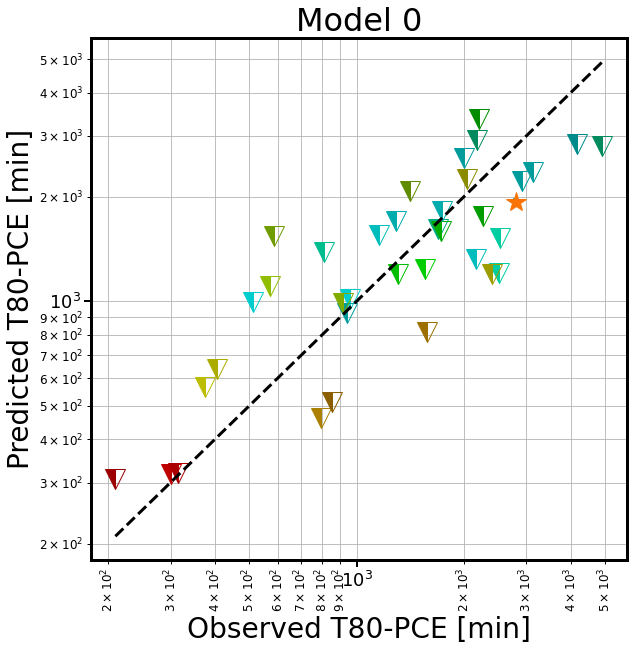

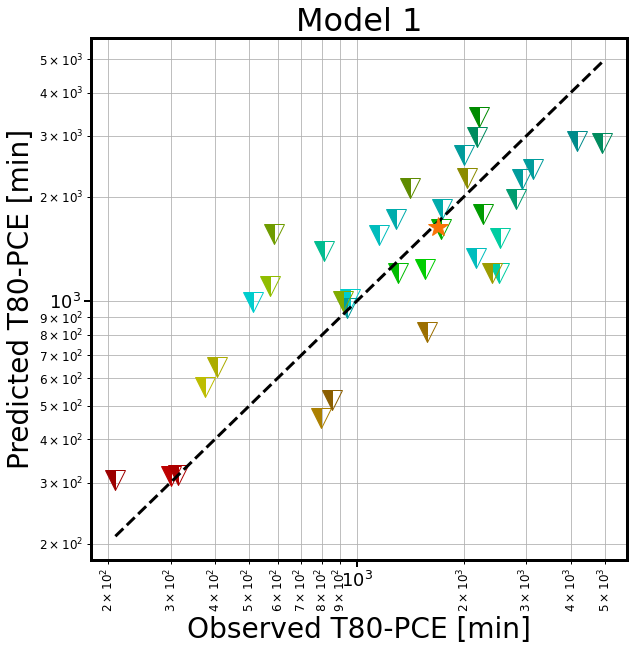

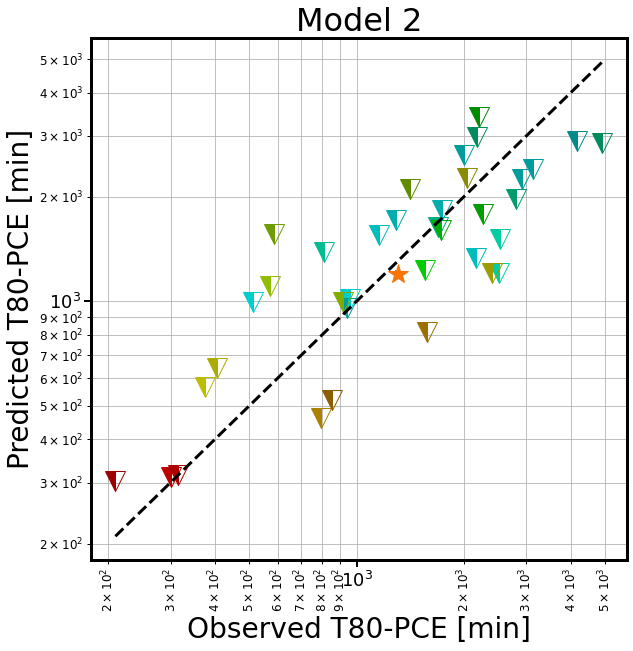

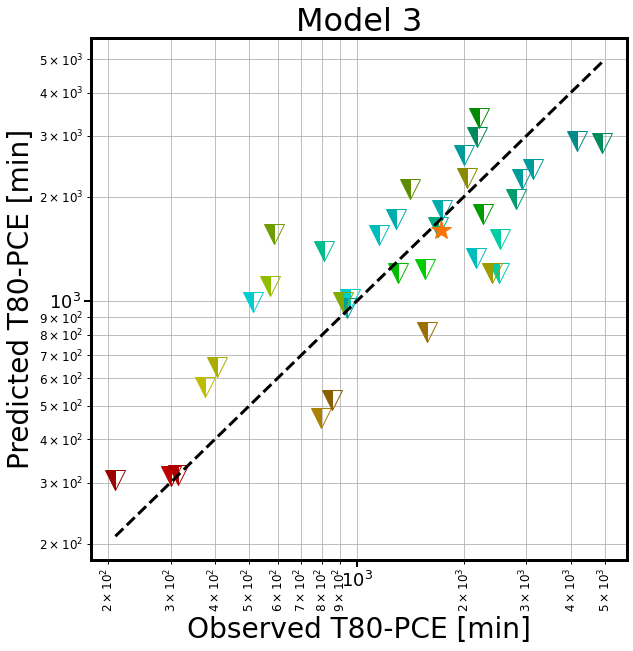

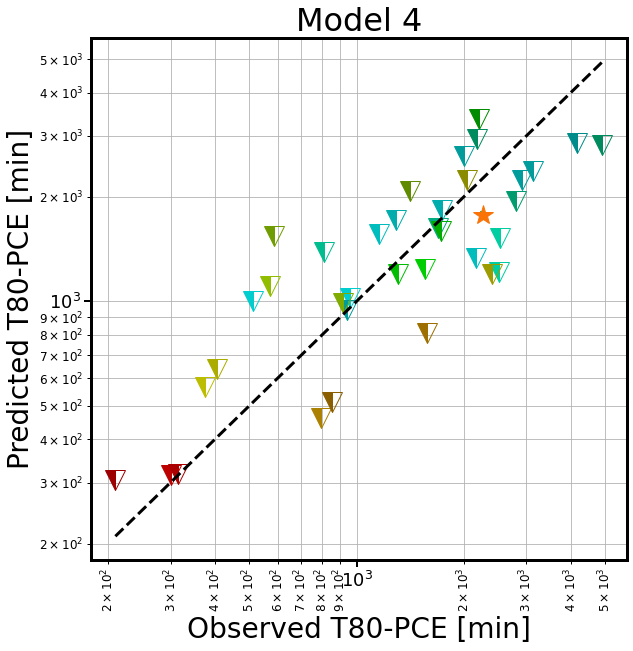

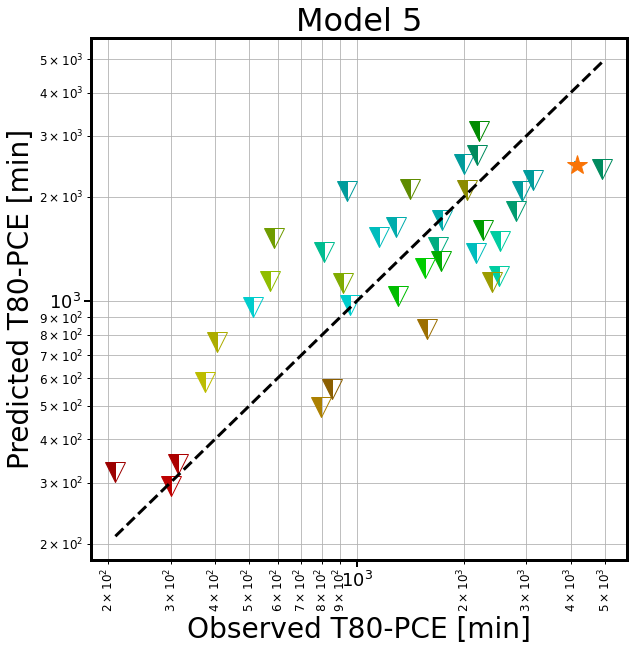

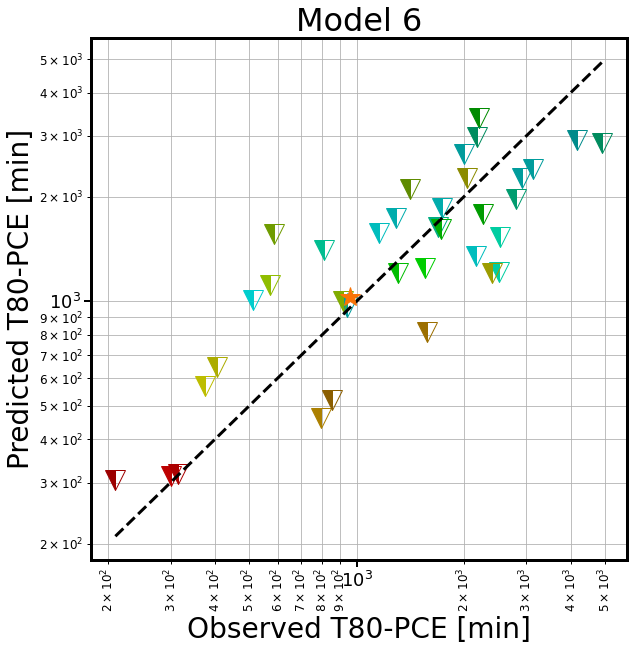

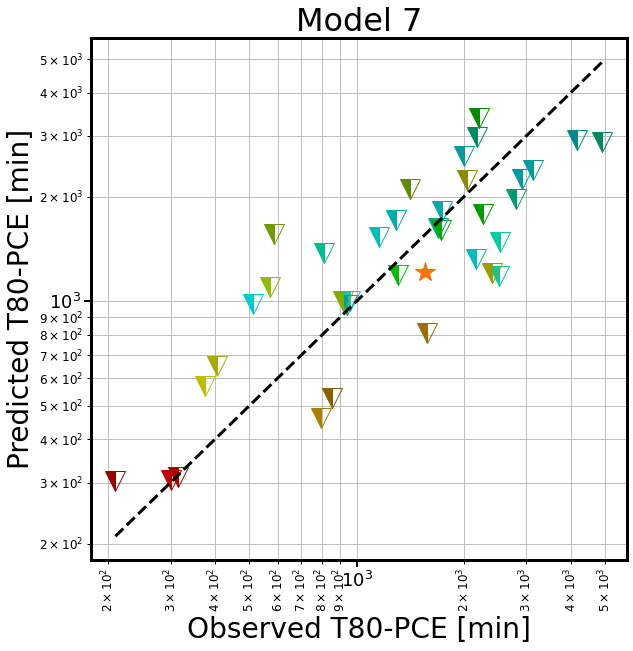

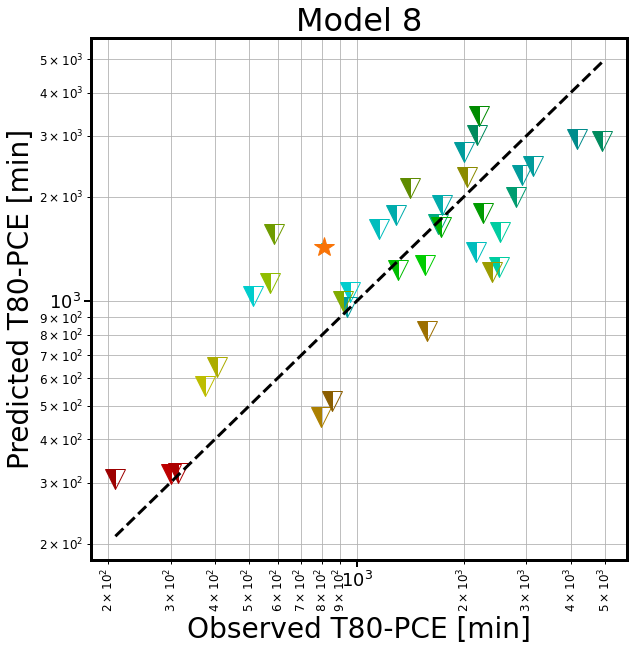

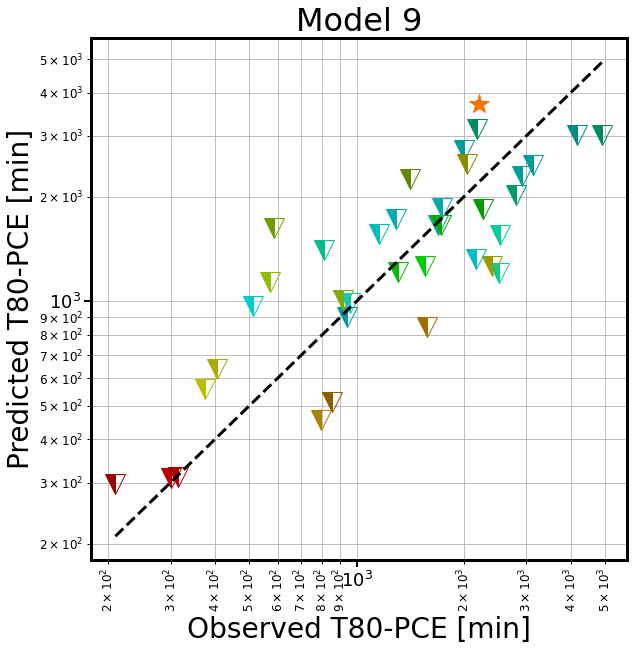

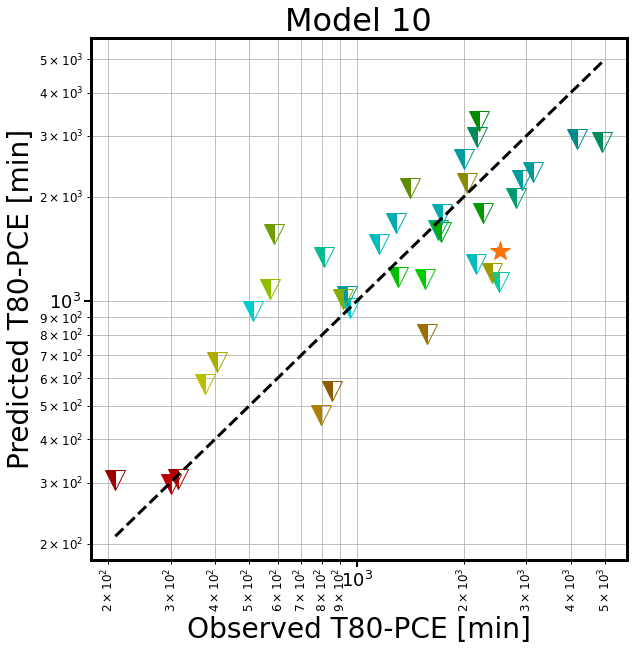

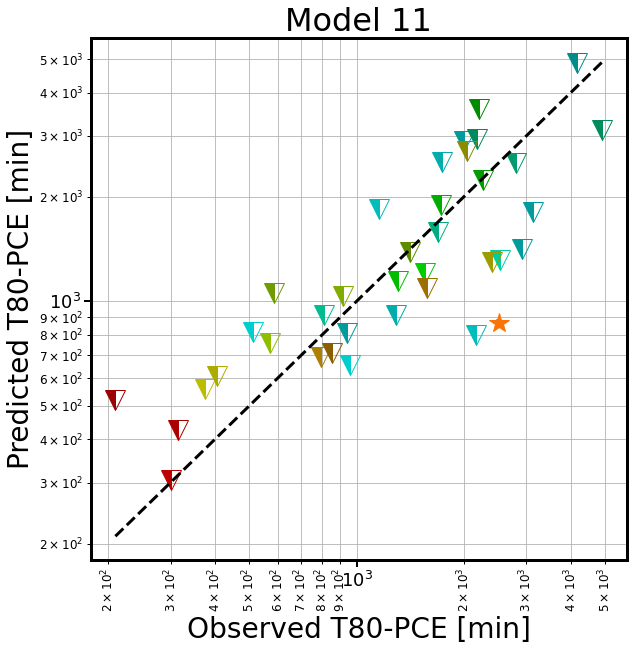

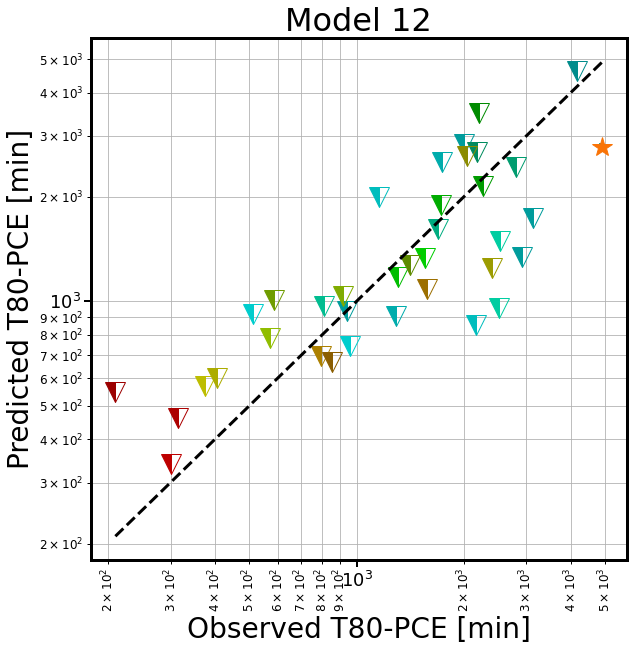

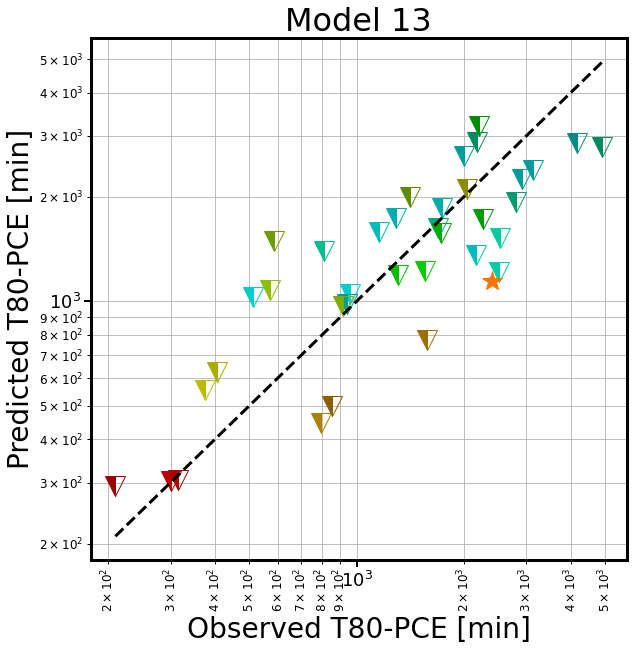

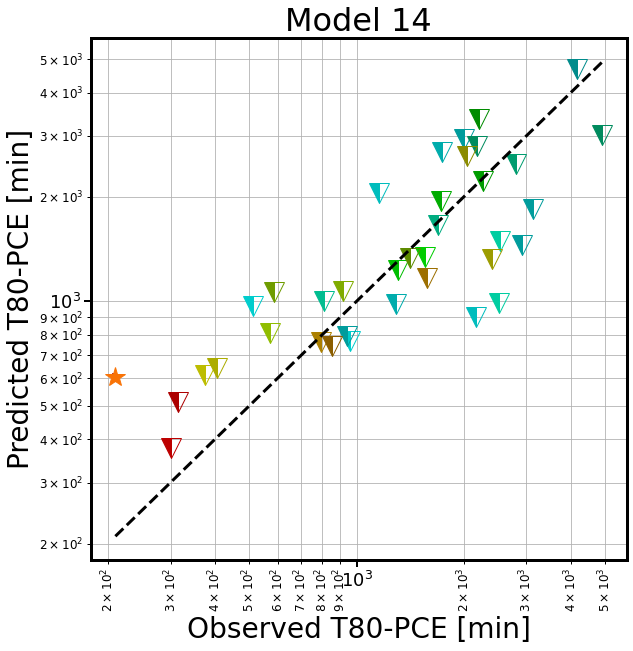

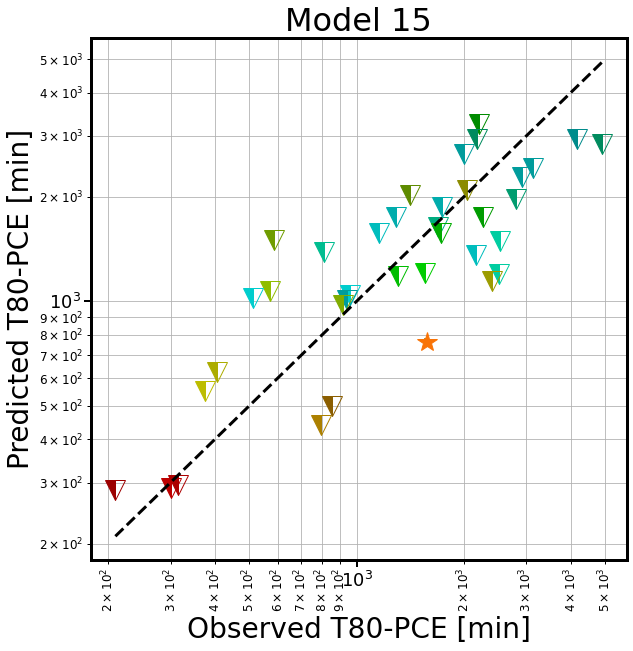

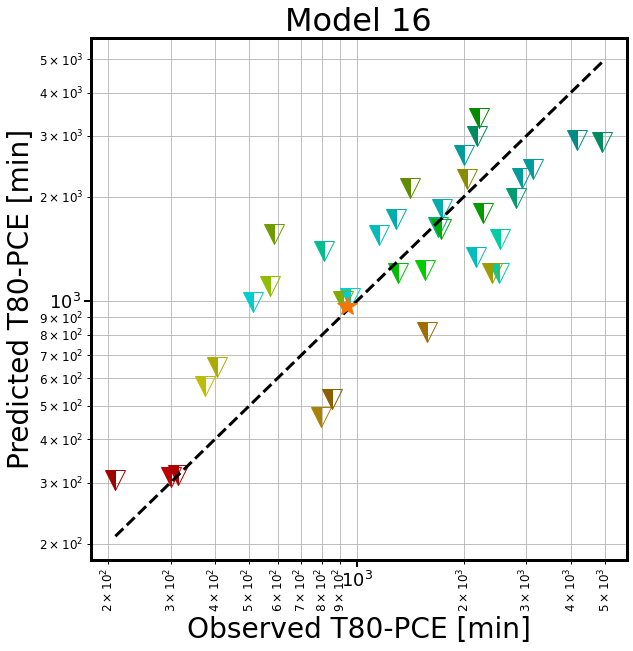

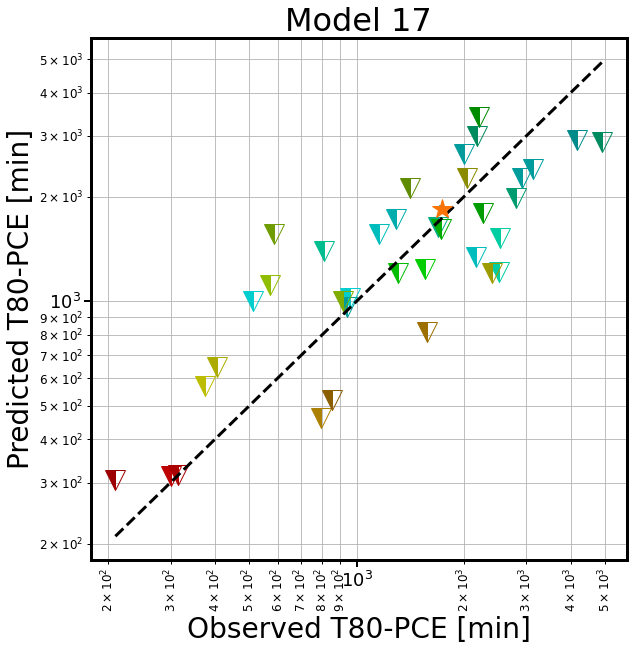

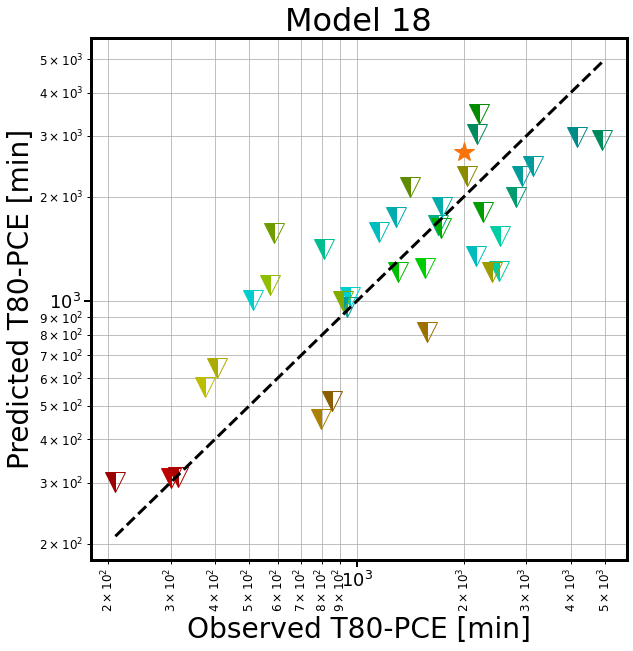

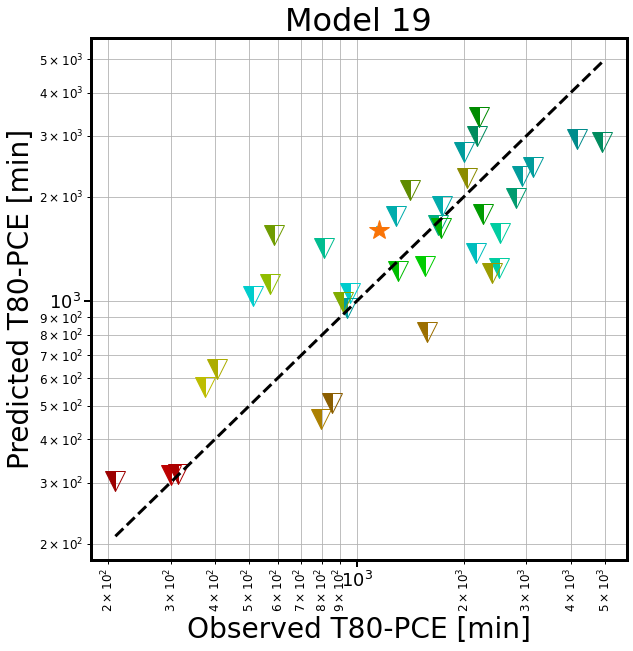

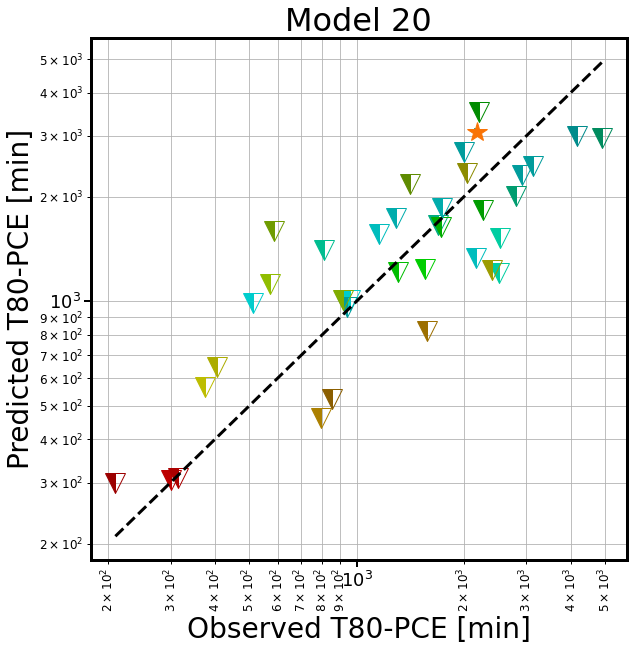

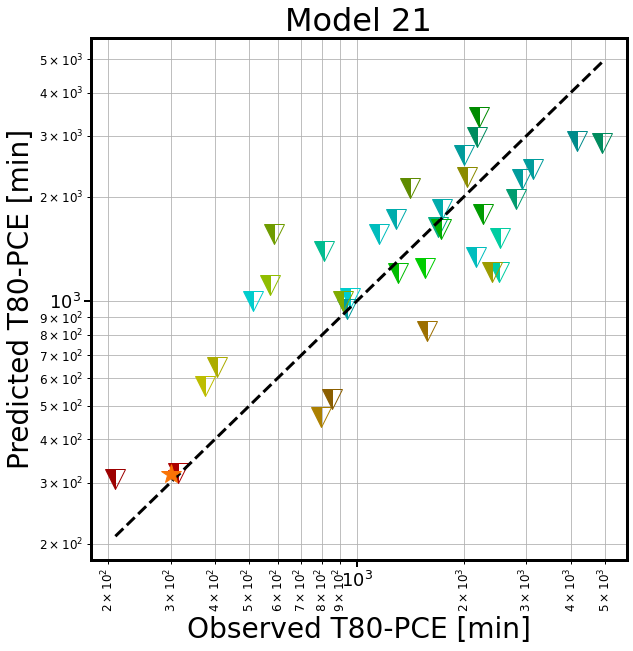

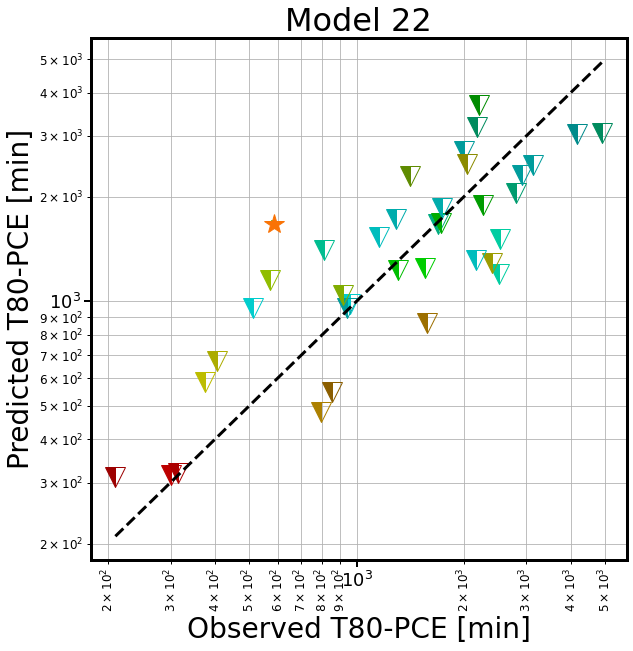

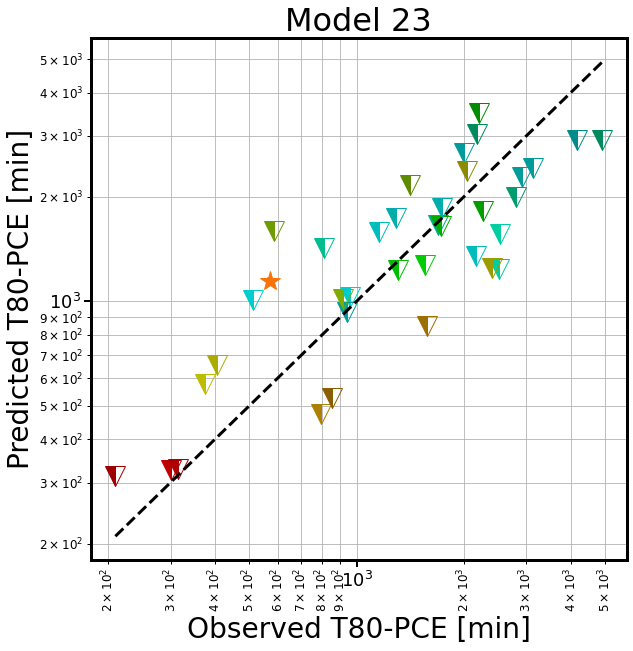

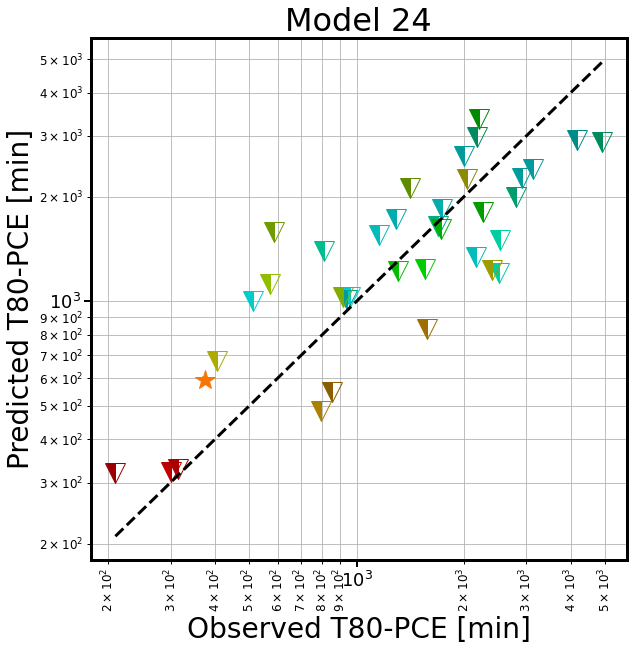

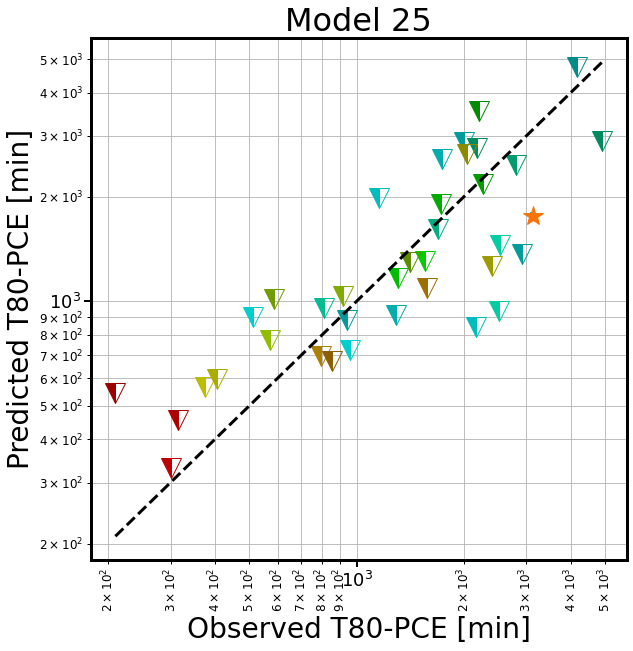

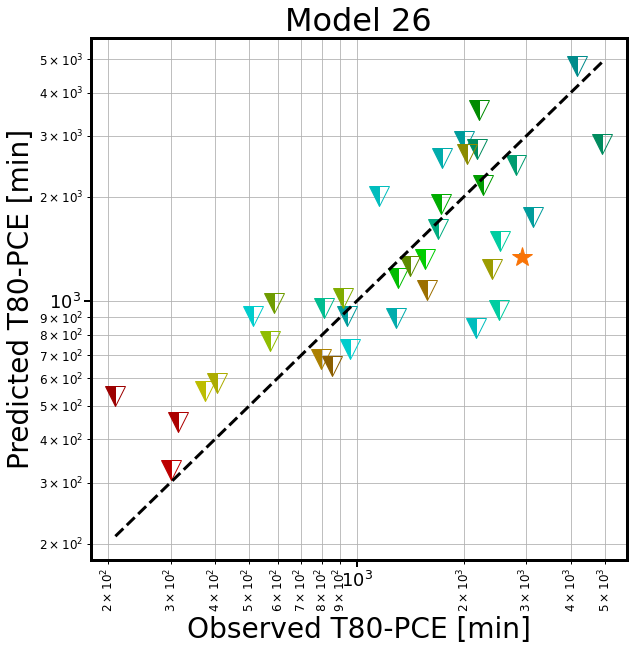

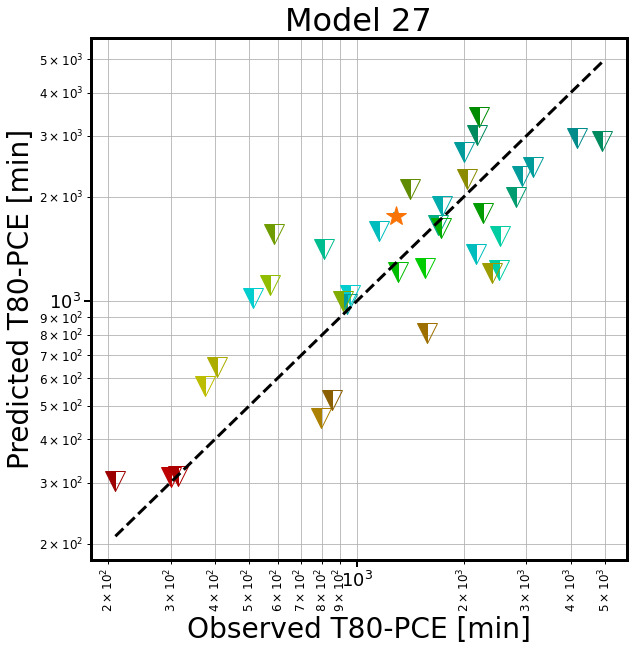

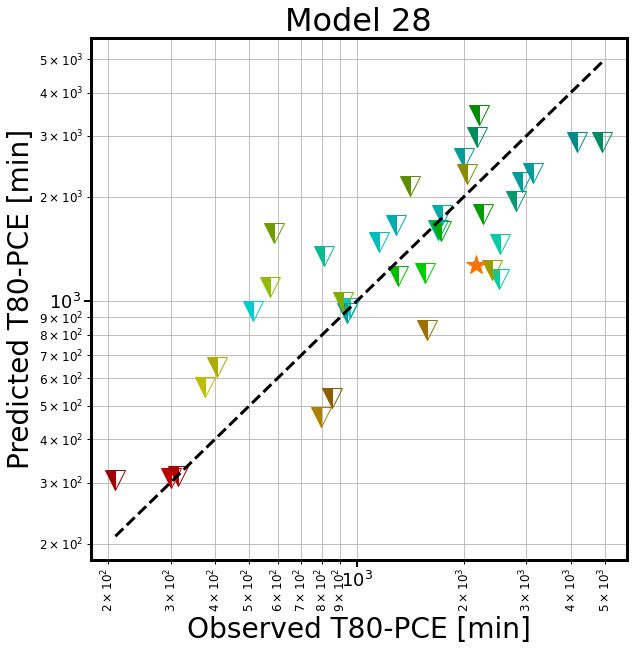

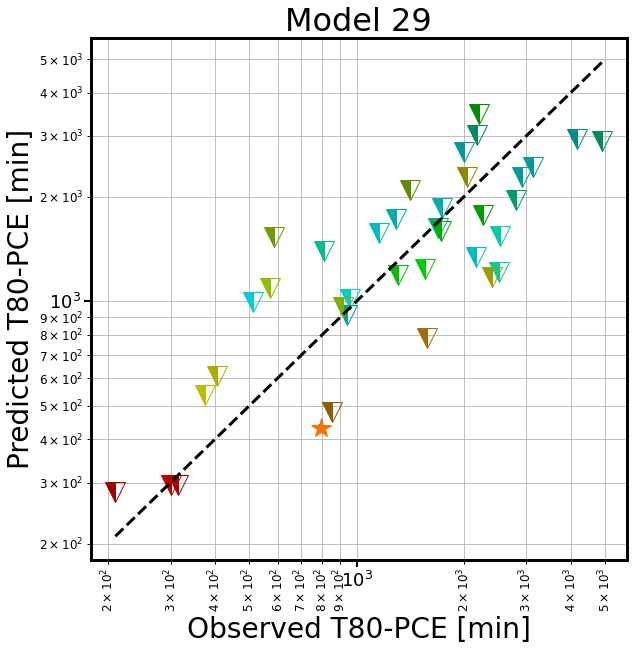

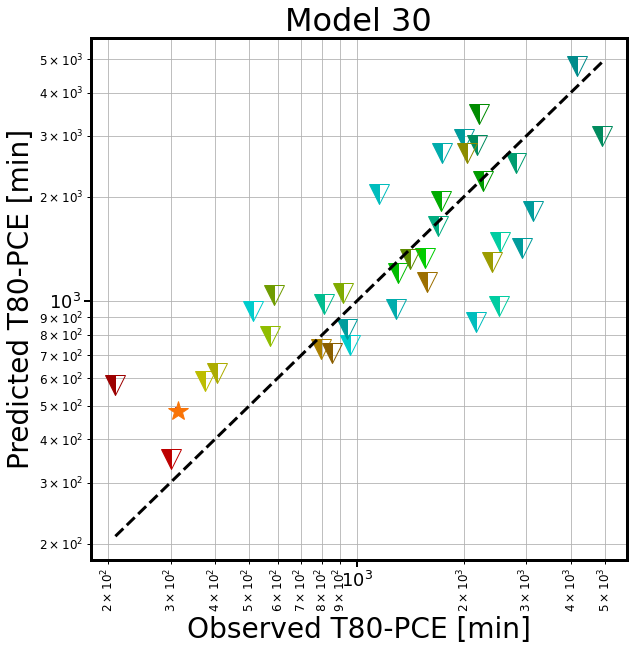

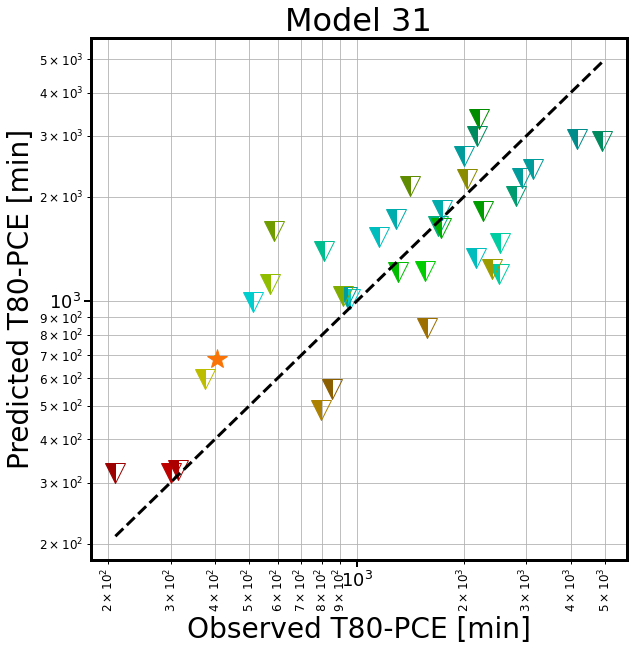

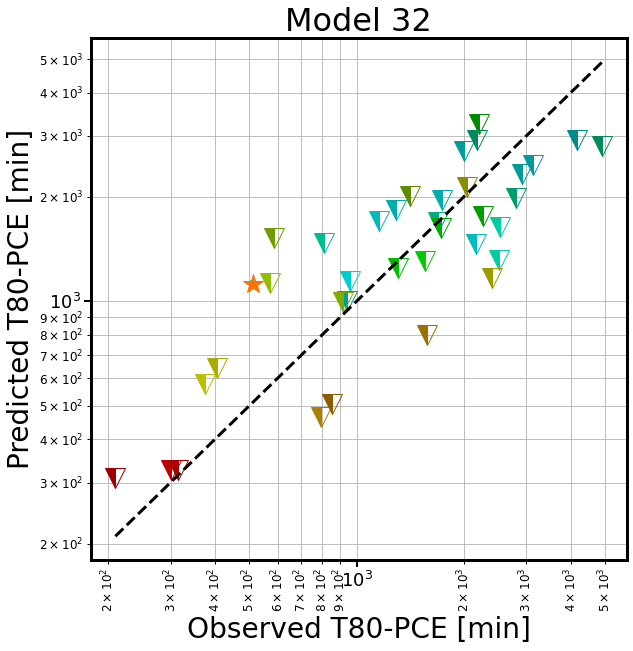

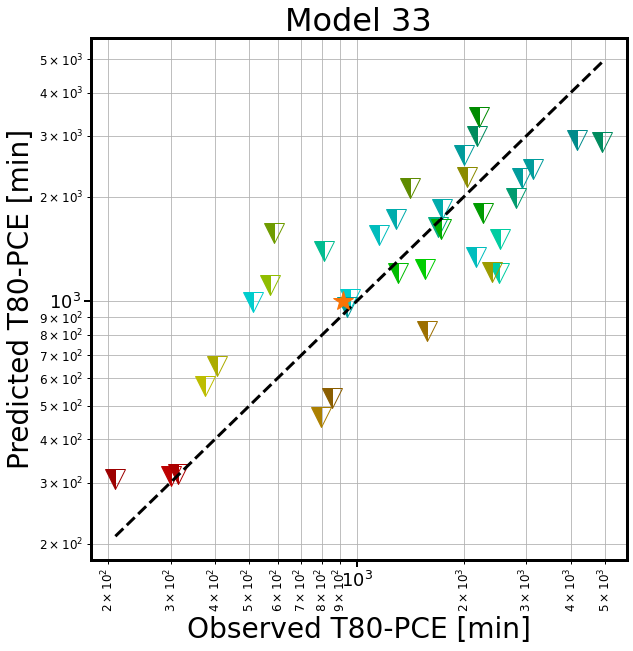

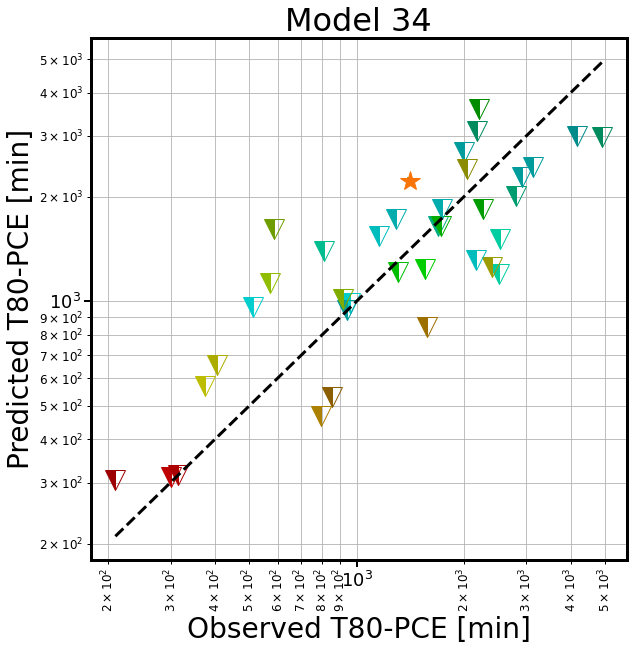

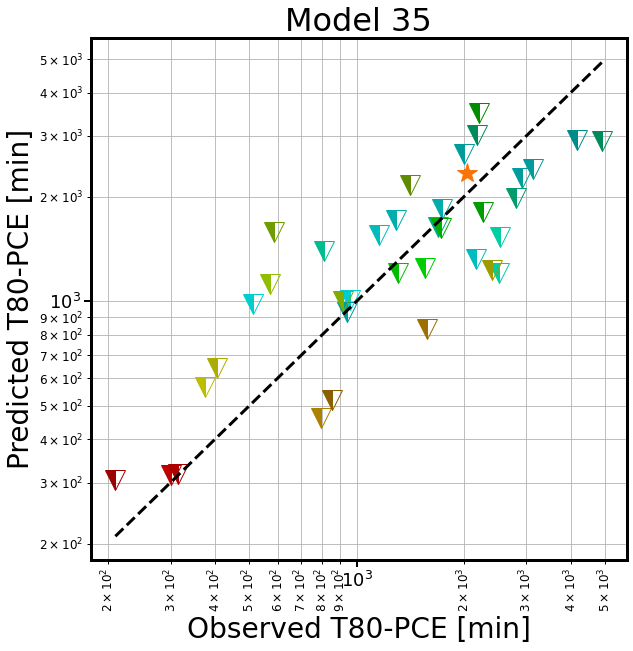

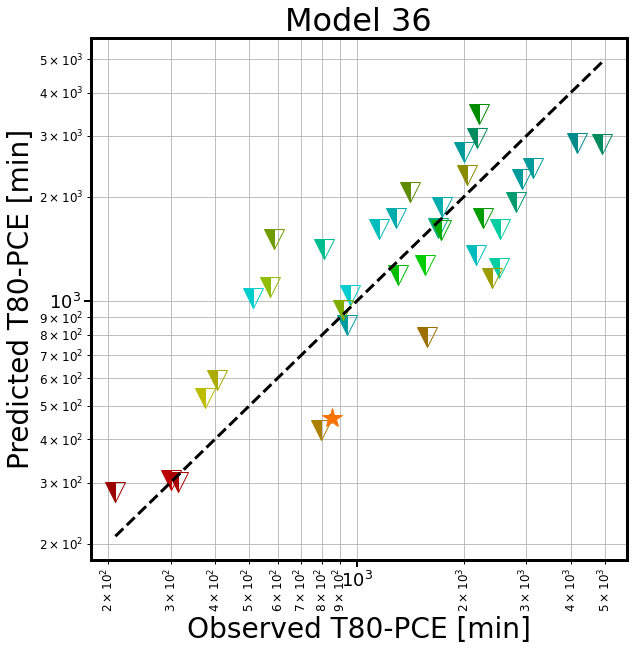

In [6]:

    


##################################################################################
#--------------------------------------------------------------------------------#
################### SETUP: SET UP THE MODEL GRID SEARCH ##########################

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)
# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,0,num=16) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE 'neg_mean_squared_error', R2 'r2', etc.
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard for large datasets, n-1 for leave-one-out

    
##################################################################################
#--------------------------------------------------------------------------------#
################### SETUP: INITIALIZE TEST ERROR METRICS #########################

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error
MAE_mean = np.zeros(n_trials) # mean absolute error when guessing mean
MAE_mean_linear = np.zeros(n_trials) # mean linear error when guessing mean

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)
# factor of how far off the prediction is
factor_off = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df_full.drop(columns=response).columns)
# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df_full.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []
# keep track of the validation error for each TTS and feature #
val_errors_all = []


##################################################################################
#--------------------------------------------------------------------------------#
################### OUTER LOOP: TEST-TRAIN SPLITS ################################

# now iterate over TTSes
# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):
    
    every = 1
    # Progress update - a small mercy for large datasets
    if kk%1 == 0:
        print('\n')
        print('---------------------------------------------------------')
        print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')
        if every == 1:
            print('Test-Train Split #',kk)
        print('\n')

    # do test/train split by pulling out one row at a time from the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS OF THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()  
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        # and normalize them (i.e. not unit variance, but rather the sum of each column is 1)
        z_train = z_train/np.sqrt(len(y_train))
        X_train[col] = z_train
        
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        # and normalize them (i.e. not unit variance, but rather the sum of each column is 1)
        z_whold = z_whold/np.sqrt(len(y_train))
        X_whold[col] = z_whold
    
    ##################################################################################
    #--------------------------------------------------------------------------------#
    ################### SECOND LOOP: ITERATE OVER FEATURE SET COMPLEXITY #############
    
    # initialize OMP variables
    index_set = [] # features that have been selected
    residuals = y_train - np.mean(y_train)
    err_thresh = 0.25
    err_thresh = 0.4
    last_error = 10000 # initialize to something really high
    marg_error = 10000 # initialize the marginal error to something really high
    count = 0
    sparsity = math.floor(0.1*len(Y))
    
    # iterate through features until the error improvement is below a predetermined threshold
    while count <= sparsity:
        
        rho_max = 0 # initialize Pearson correlation for search
        
        # find the most correlated feature with the residuals
        for feat in grand_feats_use:
            
            # try to calculate Pearson correlation
            try:
                r,_ = scipy.stats.pearsonr(X_train[feat].values,residuals.values)
                # if the correlation with residuals is the highest, save it
                if np.abs(r) > rho_max:
                    rho_max = np.abs(r)
                    best_feat = feat
            # if it can't (maybe b/c of NaNs), skip that feature
            except:
                continue
        
        # update the index set
        index_set.append(best_feat)
        X_use = X_train.copy()[index_set]
        
        # reevaluate the model using ordinary least squares
        reg = LinearRegression().fit(X_use,y_train)
        ytpred = reg.predict(X_use)
        
        # recalculate the residuals
        residuals = ytpred - y_train
        new_error = np.sum(residuals**2)
        marg_error = last_error - new_error
        last_error = new_error
        
        count += 1
        
    # once the threshold is hit, remove the last candidate feature and retrain the final model
    index_set.pop(-1)
    X_use = X_train.copy()[index_set]
    final_reg = LinearRegression().fit(X_use,y_train)
    ytpred = final_reg.predict(X_use)
    residuals = ytpred - y_train
    
    # save the model coefficients too:
    
    # reconstruct the coefficients vector, accounting for the fact that some features are set to zero 
    # by feature selection algorithm
    coeffs_vector = np.zeros(len(grand_feats_use)) # vector of *all* features
    selected_features =  index_set   # only the features that went into the model
    count = 0 # keep track of features that have been added already
    # populate nonzero coefficients in order of their correlation
    for feat in selected_features:
        for ii in range(len(coeffs_vector)):
            if feat == grand_feats_use[ii]:   # if the feature in question is one of the selected ones,                                                         
                coeffs_vector[ii] = final_reg.coef_[count] # add the corresponding coefficient in the appropriate place
                count += 1                                   # and keep track of which one it was
    # update the coefficients dataframe
    coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(grand_feats_use)),
                                                  columns=grand_feats_use))
    for ii in range(len(selected_features)):
        print('Feature',ii,':',selected_features[ii])
        print('Coefficient:',final_reg.coef_[ii])
    
    # make test set prediction
    ypred = final_reg.predict(X_whold[index_set].values.reshape(1, -1))

    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    MAE_mean[kk] = np.abs(y_whold - np.mean(y_train))
    MAE_mean_linear[kk] = np.abs(np.exp(y_whold) - np.exp(np.mean(y_train)))/np.abs(np.exp(y_whold))

    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])

    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    factor_off[kk] = np.exp(ypred)/np.exp(y_whold)
    
    if not parity_plot_test:
        fig, ax = plt.subplots()
        for ii in range(len(y_train)):
            idx = y_train.index[ii]
            T = featdata_df['Temp (deg C)'][idx]
            RH = featdata_df['RH (%)'][idx]
            pct_O2 = featdata_df['Oxygen (%)'][idx]
            N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = featdata_df['MA fraction'][idx]
            if Log_transform:
                ax.loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
            else:
                ax.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
            #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

        # plot perfect prediction line and +/-50% error bounds
        if Log_transform:
            plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                                    np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                                    num=2)
            plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
            #plt.plot(plotRange,2*plotRange,color='r',marker = ' ',linestyle='--')
            #plt.plot(plotRange,0.5*plotRange,color='r',marker = ' ',linestyle='--')
        else:
            plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
            ax.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        ax.grid(which='both')

        if response == 't_Jsc75':
            ax.set_xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
            ax.set_ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
        elif response == 't_Jsc80':
#             ax.set_xlabel('Observed $t_{J_\mathrm{sc},80}$ [min]')
#             ax.set_ylabel('Predicted $t_{J_\mathrm{sc},80}$ [min]')
            ax.set_xlabel('Observed T80-$J_\mathrm{sc}$ [min]')
            ax.set_ylabel('Predicted T80-$J_\mathrm{sc}$ [min]')
        elif response == 't_PCE75':
            ax.set_xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
            ax.set_ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
        elif response == 't_PCE80':
            ax.set_xlabel('Observed T80-PCE [min]')
            ax.set_ylabel('Predicted T80-PCE [min]')
        else:
            ax.set_xlabel('Observed Value')
            ax.set_ylabel('Predicted Value')
        #big_ax[0,feats_to_use].set_xticks(fontsize=16)
        #big_ax[0,feats_to_use].set_yticks(fontsize=16)
        ax.set_title('Model {0:d}'.format(kk))

        # plot test data as above, with environment denoted by marker appearance and composition by marker size
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii]
            T = featdata_df['Temp (deg C)'][idx]
            RH = featdata_df['RH (%)'][idx]
            pct_O2 = featdata_df['Oxygen (%)'][idx]
            N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = featdata_df['MA fraction'][idx]
            if Log_transform:
                ax.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
                # plot orange star to identify test samples
                ax.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
            else:
                ax.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
                # plot orange star to identify test samples
                ax.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
        
        subs = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]  # ticks to show per decade
        ax.xaxis.set_minor_locator(ticker.LogLocator(subs=subs)) #set the ticks position
        #ax.xaxis.set_major_formatter(ticker.NullFormatter())   # remove the major ticks
        ax.xaxis.set_minor_formatter(ticker.FuncFormatter(ticks_format))  #add the custom ticks
        ax.yaxis.set_minor_locator(ticker.LogLocator(subs=subs)) #set the ticks position
        #ax.yaxis.set_major_formatter(ticker.NullFormatter())   # remove the major ticks
        ax.yaxis.set_minor_formatter(ticker.FuncFormatter(ticks_format))  #add the custom ticks
        
        ax.tick_params(axis ='both', which ='major', labelsize = 18)
        ax.tick_params(axis ='both', which ='minor', labelsize = 12)
        ax.tick_params(axis ='x', which ='minor', rotation = 90)

# aggregate  basic coefficient statistics
coeffs = coeffs_df.columns # save coefficient names
avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations

# print test stats
print('-----------------------------------------------------------------')
print('STATISTICS:')
print('\n')
print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

#MAE_guess_mean = np.mean(np.abs(y_train-np.mean(y_train))/np.abs(y_train))*100

print('Mean Absolute Error When Guessing Mean =',np.round(np.mean(MAE_mean),3))
print('Mean Linear Error When Guessing Mean =',np.round(np.mean(MAE_mean_linear)*100,1),'%')
print('Median Absolute Error When Guessing Mean =',np.round(np.median(MAE_mean),3))
print('Median Linear Error When Guessing Mean =',np.round(np.median(MAE_mean_linear)*100,1),'%')

print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
print('Median Linear Error =',np.round(np.median(linear_error)),'%')

# function to ID values less than 50
def condition_50(x):
    return x <= 50

pct_under_50 = sum(condition_50(x) for x in linear_error)/len(linear_error)*100
print('Fraction of Runs Predicted to within 50%:',np.round(pct_under_50,2),'%')

factor_two = factor_off[np.where(factor_off > 0.5)]
factor_two = factor_two[np.where(factor_two < 2)]
pct_within_factor_two = len(factor_two)/len(factor_off)*100
print('Fraction of Runs Predicted within a Factor of Two:',np.round(pct_within_factor_two,2),'%')

print('\n')
print('Index of Median Model:',np.argmin(np.abs(np.median(MAE_pct)-MAE_pct)))
print('Index of Best Model:',np.argmin(MAE_pct))
print('Index of Worst Model:',np.argmax(MAE_pct))

print('-----------------------------------------------------------------')
print('\n')


    
#     # save the model coefficients to the respective row in the DF
#     if unshrink_coefficients:
#         # reconstruct the full model coefficients
#         coeffs_vector = np.zeros(len(final_model.coef_))
#         count = 0
#         for ii in range(len(final_model.coef_)):
#             if final_model.coef_[ii] != 0:
#                 coeffs_vector[ii] = shrunk_model.coef_[count]
#                 count += 1
#         coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
#                                                   columns=coded_df.drop(columns=response).columns))
#     else:
#         coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

#     # calculate and save Shapley values
#     shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
#     Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))


<ipython-input-8-aac60b810f82>:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-8-aac60b810f82>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-8-aac60b810f82>:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fancy_labels,rotation=90)


Text(0.5, 0.9, 'Feature Weights')

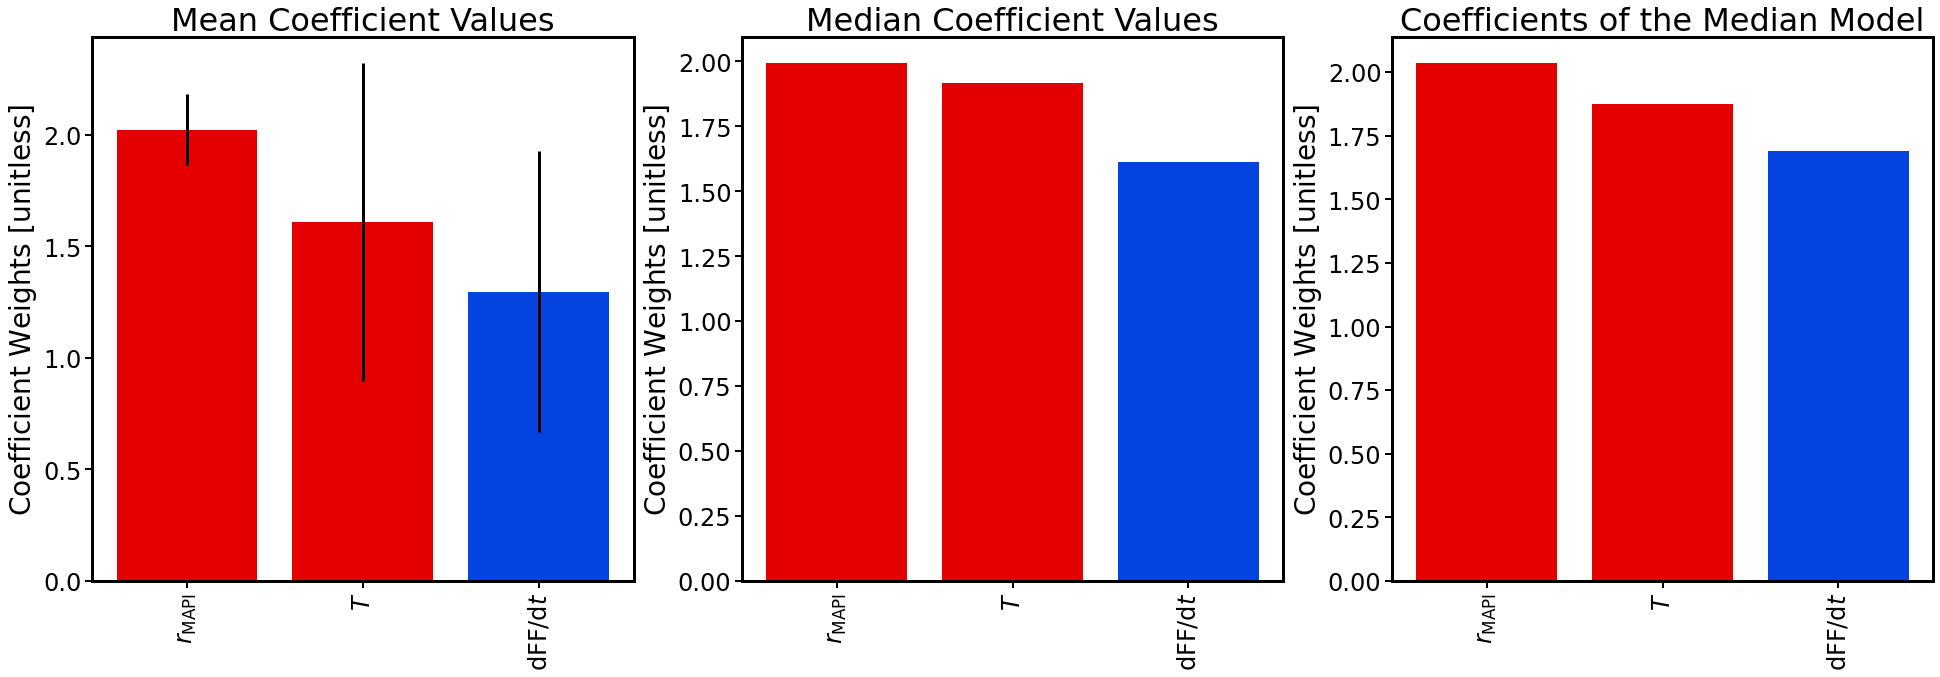

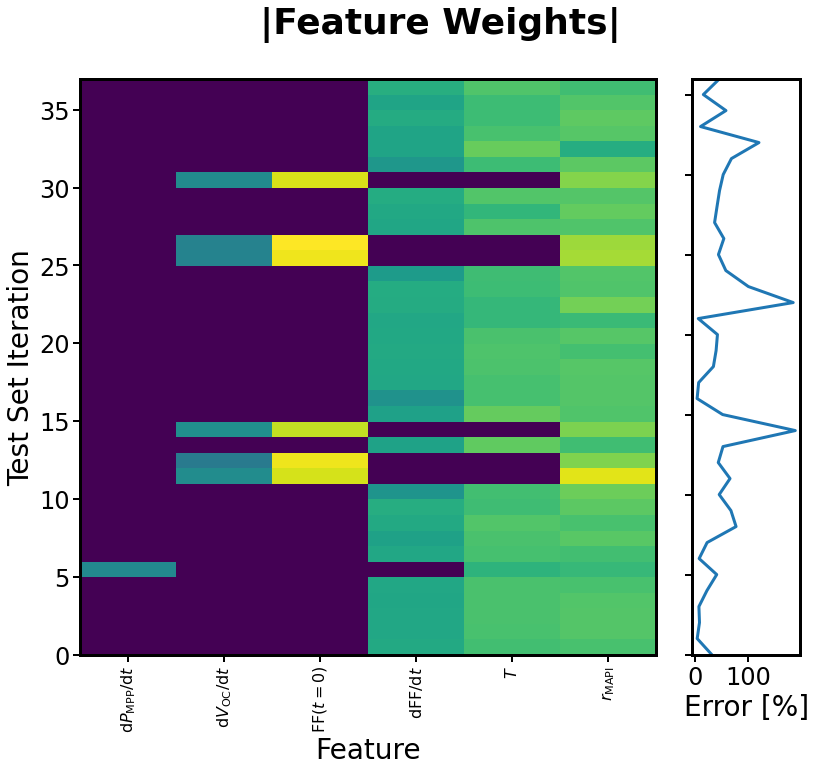

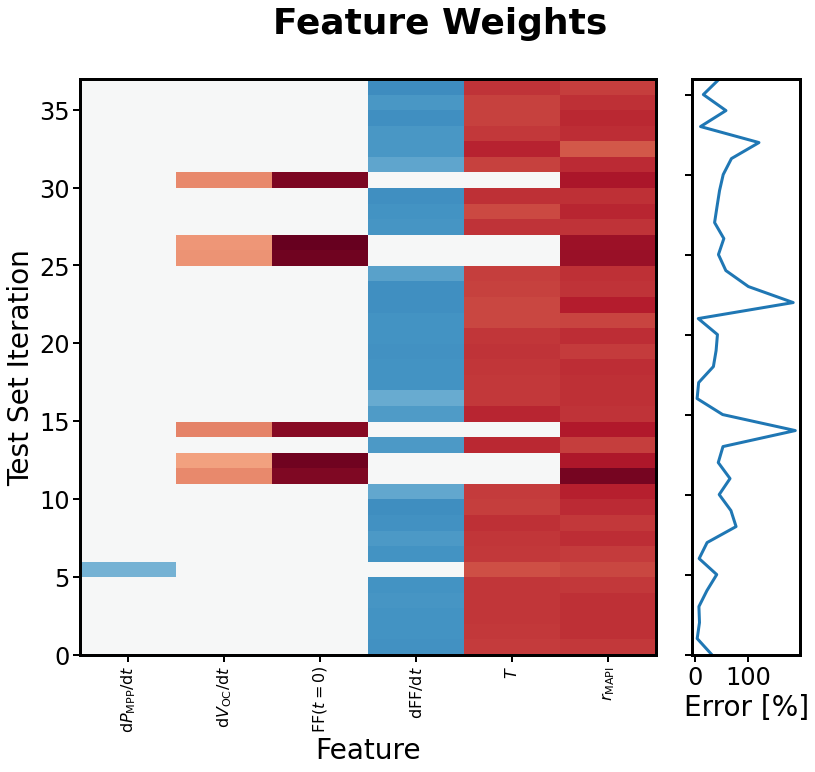

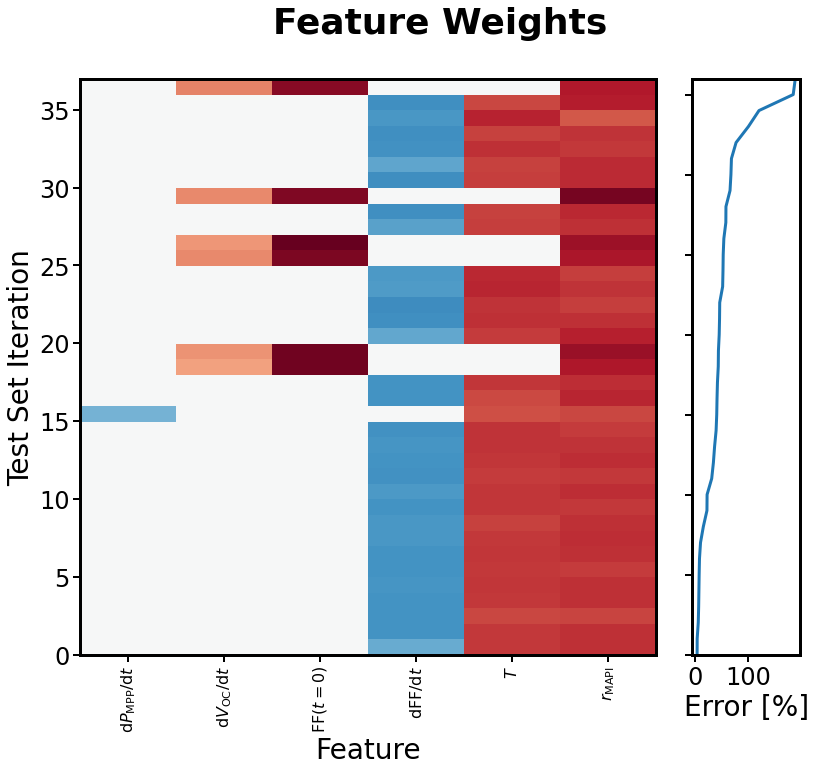

In [8]:
# make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
selected_df = coeffs_df.copy()
coeffs = coeffs_df.columns

for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
    selected_df.iloc[ii] = logic

# make a DF of key statistics on the coefficient values
stats_df = coeffs_df.copy()

# initialize lists of key stats
medians = []
means = []
stds = []

# populate the lists...
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
# ...and add them to the DataFrame 
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds

# plot the median values of the coefficients
#plt.figure(figsize=(10,10))
#plt.bar(stats_df.columns,stats_df.loc['medians'])
#plt.xticks(rotation=90)

# assign bar colors to mean coefficient values
bar_colors_mean = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(means[jj]) == 1:
            bar_colors_mean.append('xkcd:red')
        else:
            bar_colors_mean.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors_mean.append('xkcd:blue')
        else:
            bar_colors_mean.append('xkcd:red')

# assign bar colors to median coefficient values
bar_colors_median = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:red')
        else:
            bar_colors_median.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:blue')
        else:
            bar_colors_median.append('xkcd:red')

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = coeffs # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df['medians'] = np.abs(medians) # add median coefficient values
bars_df['error'] = stds # add standard deviations
bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['means'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

# define nice-looking labels
fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# initialize the figure for comparing coefficients
fig, ax = plt.subplots(1,3,figsize=(33,10))  

# plot the means with error bars represented by the standard deviation
ax[0].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
ax[0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0].set_title('Mean Coefficient Values')

# now re-sort the DF by descending medians
bars_df = bars_df.sort_values(by = 'medians', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_meds_df = bars_df[bars_df['medians'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in nz_meds_df['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and plot the median coefficient weights
ax[1].bar(nz_meds_df['coeffs'],nz_meds_df['medians'],color=nz_meds_df['colors_median'])
ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
ax[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1].set_title('Median Coefficient Values')

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    div_cmap = 'RdBu_r'
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    div_cmap = 'RdBu'
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df.copy()[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and make the plot
ax[2].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2].set_xticklabels(fancy_labels,rotation=90)
ax[2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2].set_title('Coefficients of the Median Model')



# make a figure with all the coefficients in a heat map
fig = plt.figure(figsize=(10,10))

# to save space, drop all coefficients that are always zero
nonzero = []
for coeff in coeffs_df.columns:
    if np.any(coeffs_df[coeff] != 0):
        nonzero.append(coeff)
        
coeffs_df_nz = coeffs_df[nonzero]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df_nz.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)
        
# first panel: heat map
ax1 = fig.add_axes([0,0,0.8,0.8])
ax1.pcolor(np.abs(coeffs_df_nz))
ax1.set_xticks(np.arange(0.5, len(coeffs_df_nz.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig.add_axes([0.85,0,0.15,0.8])
# ax2.plot(MAE_pct,range(len(MAE_pct)))
# ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])

ax2.plot(linear_error,range(len(linear_error)))
ax2.set_ylim([np.min(range(len(linear_error))),np.max(range(len(linear_error)))])

ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig.suptitle('|Feature Weights|', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map
fig2 = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df_nz.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)
        
# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_df_nz, cmap = div_cmap, vmin = -np.max(np.max(np.abs(coeffs_df_nz))), vmax = np.max(np.max(np.abs(coeffs_df_nz))))
ax1.set_xticks(np.arange(0.5, len(coeffs_df_nz.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
# ax2.plot(MAE_pct,range(len(MAE_pct)))
# ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.plot(linear_error,range(len(linear_error)))
ax2.set_ylim([np.min(range(len(linear_error))),np.max(range(len(linear_error)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map; this time sort everything by test error
fig2 = plt.figure(figsize=(10,10))

# augment the coeffs_df with an MAE column
coeffs_aug = coeffs_df_nz.copy()
#coeffs_aug['MAE'] = MAE_pct
coeffs_aug['MAE Linear'] = linear_error

# sort the runs by error
# coeffs_aug = coeffs_aug.sort_values(by='MAE',axis=0,ascending=True)
# MAE_sorted = coeffs_aug['MAE']
# coeffs_aug = coeffs_aug.drop('MAE',axis=1)

coeffs_aug = coeffs_aug.sort_values(by='MAE Linear',axis=0,ascending=True)
MAE_sorted = coeffs_aug['MAE Linear']
coeffs_aug = coeffs_aug.drop('MAE Linear',axis=1)

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df_nz.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_aug, cmap = div_cmap, vmin = -np.max(np.max(np.abs(coeffs_aug))), vmax = np.max(np.max(np.abs(coeffs_aug))))
ax1.set_xticks(np.arange(0.5, len(coeffs_aug.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_sorted,range(len(MAE_sorted)))
ax2.set_ylim([np.min(range(len(MAE_sorted))),np.max(range(len(MAE_sorted)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')